# Clasificaci√≥n No Balanceada en Inversiones Startups (Crunchbase)

Este trabajo aborda un problema de **clasificaci√≥n binaria no balanceada** a partir de un dataset abierto de inversiones en startups, disponible en [Kaggle - Startup Investments Crunchbase](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

## Descripci√≥n del Proyecto

Este proyecto se desarrolla para la asignatura de **Miner√≠a de Datos**, como parte del trabajo final grupal. El objetivo es aplicar t√©cnicas de an√°lisis y modelado sobre un conjunto de datos reales para abordar un problema de clasificaci√≥n desequilibrada.

A partir del dataset original, se ha redefinido el problema como una clasificaci√≥n binaria no balanceada. Por ejemplo, se puede predecir si una startup ha recibido financiaci√≥n por encima de un determinado umbral, o si pertenece a un grupo de industrias consideradas ‚Äúde alto crecimiento‚Äù.

## Objetivos

1. **Formulaci√≥n del problema** como tarea de clasificaci√≥n binaria no balanceada.
2. **An√°lisis exploratorio** de las variables del dataset.
3. **Preparaci√≥n de los datos**, incluyendo tratamiento de valores perdidos, normalizaci√≥n, codificaci√≥n y detecci√≥n de outliers.
4. Aplicaci√≥n de **t√©cnicas de aprendizaje supervisado**:
   - **K-Nearest Neighbors (KNN)**
   - **√Årboles de Decisi√≥n**
5. Evaluaci√≥n mediante **m√©tricas adecuadas** para clasificaci√≥n no balanceada (como *F1-Score*, *balanced accuracy*, *AUC*, etc.) y **validaci√≥n cruzada**.
6. Uso de **pipelines y transformadores** para automatizar el preprocesamiento.
7. Aplicaci√≥n de t√©cnicas de **muestreo (undersampling/oversampling)** y **ajuste de umbrales**.
8. Estudio de la **interpretabilidad del modelo final**.

## Estructura del Notebook

Este notebook est√° estructurado en las siguientes secciones:

- [1. Carga y descripci√≥n del dataset](#)
- [2. An√°lisis exploratorio de los datos (EDA)](#)
- [3. Formulaci√≥n del problema de clasificaci√≥n binaria no balanceada](#)
- [4. Preprocesamiento de datos](#)
- [5. Construcci√≥n del pipeline con KNN](#)
- [6. Evaluaci√≥n del modelo y an√°lisis de resultados](#)
- [7. √Årboles de decisi√≥n y comparaci√≥n](#)
- [8. Interpretabilidad del modelo final](#)
- [9. Conclusiones](#)

## 1. Elecci√≥n del problema

El problema elegido se basa en el dataset **Startup Investments - Crunchbase**, disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo es construir un modelo de **clasificaci√≥n binaria no balanceada** que permita **predecir si una startup ser√° adquirida** o no. Para ello, hemos definido la variable objetivo `target` de la siguiente forma:

- `target = 1` si la columna `status` es `"acquired"`
- `target = 0` en cualquier otro caso (por ejemplo: `closed`, `ipo`, `operating`, etc.)

Este planteamiento genera un claro desbalance entre clases, ya que el n√∫mero de startups adquiridas es mucho menor que el resto.

Comenzamos leyendo el dataset original sobre inversiones en startups, proporcionado por Crunchbase y disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo en esta fase inicial es familiarizarnos con la estructura de los datos: n√∫mero de ejemplos, variables disponibles, tipos de datos y primeras observaciones. Esto nos permitir√° definir correctamente el problema de clasificaci√≥n binaria no balanceada.

El archivo utilizado se llama `investments_VC.csv` y se encuentra en la carpeta `data/`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, precision_recall_curve, auc

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn_neighbors

In [2]:
ruta_datos = "data/investments_VC.csv"

df = pd.read_csv(ruta_datos, encoding="latin1")

print("Dimensiones del dataset: ", df.shape)
pd.set_option('display.max_columns', None)
df.head()

Dimensiones del dataset:  (54294, 39)


permalink                name  \
0            /organization/waywire            #waywire   
1  /organization/tv-communications  &TV Communications   
2    /organization/rock-your-paper   'Rock' Your Paper   
3   /organization/in-touch-network   (In)Touch Network   
4   /organization/r-ranch-and-mine  -R- Ranch and Mine   

                    homepage_url  \
0         http://www.waywire.com   
1          http://enjoyandtv.com   
2   http://www.rockyourpaper.org   
3  http://www.InTouchNetwork.com   
4                            NaN   

                                       category_list        market   \
0         |Entertainment|Politics|Social Media|News|          News    
1                                            |Games|         Games    
2                             |Publishing|Education|    Publishing    
3  |Electronics|Guides|Coffee|Restaurants|Music|i...   Electronics    
4                      |Tourism|Entertainment|Games|       Tourism    

   funding_total_usd      status country_code state_code         region  \
0          17,50,000    acquired          USA         NY  New York City   
1          40,00,000   operating          USA         CA    Los Angeles   
2             40,000   operating          EST        NaN        Tallinn   
3          15,00,000   operating          GBR        NaN         London   
4             60,000   operating          USA         TX         Dallas   

          city  funding_rounds  founded_at founded_month founded_quarter  \
0     New York             1.0  2012-06-01       2012-06         2012-Q2   
1  Los Angeles             2.0         NaN           NaN             NaN   
2      Tallinn             1.0  2012-10-26       2012-10         2012-Q4   
3       London             1.0  2011-04-01       2011-04         2011-Q2   
4   Fort Worth             2.0  2014-01-01       2014-01         2014-Q1   

   founded_year first_funding_at last_funding_at       seed    venture  \
0        2012.0       2012-06-30      2012-06-30  1750000.0        0.0   
1           NaN       2010-06-04      2010-09-23        0.0  4000000.0   
2        2012.0       2012-08-09      2012-08-09    40000.0        0.0   
3        2011.0       2011-04-01      2011-04-01  1500000.0        0.0   
4        2014.0       2014-08-17      2014-09-26        0.0        0.0   

   equity_crowdfunding  undisclosed  convertible_note  debt_financing  angel  \
0                  0.0          0.0               0.0             0.0    0.0   
1                  0.0          0.0               0.0             0.0    0.0   
2                  0.0          0.0               0.0             0.0    0.0   
3                  0.0          0.0               0.0             0.0    0.0   
4              60000.0          0.0               0.0             0.0    0.0   

   grant  private_equity  post_ipo_equity  post_ipo_debt  secondary_market  \
0    0.0             0.0              0.0            0.0               0.0   
1    0.0             0.0              0.0            0.0               0.0   
2    0.0             0.0              0.0            0.0               0.0   
3    0.0             0.0              0.0            0.0               0.0   
4    0.0             0.0              0.0            0.0               0.0   

   product_crowdfunding  round_A  round_B  round_C  round_D  round_E  round_F  \
0                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4                   0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   round_G  round_H  
0      0.0      0.0  
1      0.0      0.0  
2      0.0      0.0  
3      0.0      0.0  
4      0.0      0.0

## 0. Limpieza de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

Para reducir datos redundantes e innecesarios, eliminamos columnas que no nos hacen falta para nuestro modelo:
- `permalink`: Es una URL √∫nica que identifica a la empresa dentro de la base de datos original.
- `name`: aunque representa el nombre de la empresa, no es necesario para los objetivos de clasificaci√≥n ni para el an√°lisis cuantitativo, por lo que tambi√©n se ha descartado.
- `debt-financing`: la eliminamos porque consideramos que distorsiona el resultado, dado que estar en deuda no es necesariamente un buen predictor del √©xito, en su lugar, nos centramos en `venture`, que se es considerafo el equivalente a la inversi√≥n.
- `post_ipo_equity`: financiaci√≥n despu√©s de una salida a bolsa (IPO). No es relevante para nuestro an√°lisis porque estamos interesados en startups, no en empresas ya consolidadas o cotizadas.
- `post_ipo_debt`: deuda despu√©s de haber salido a bolsa. No es relevante para nuestro an√°lisis porque estamos interesados en startups, no en empresas ya consolidadas o cotizadas.


In [4]:
df = df.drop(columns=['permalink', 'name', "post_ipo_equity", "post_ipo_debt", "debt_financing"], axis=1)

As√≠ mismo, podemos eliminar duplicados si es que hay alguno

In [5]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(54294, 34)
(49377, 34)


Podemos observar que hay variables con formato incorrecto en el nombre y otras con espacios como `market` y `funding_total_usd`, por lo que lo arreglamos:

In [6]:
# Nos aseguramos de que no haya espacios en los nombres de las variables
df.columns = df.columns.str.strip()
# Convertimos la variable funding_total_usd a un float y cambiamos los - por NaN
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'].str.replace(',', ''), errors='coerce')

Tambi√©n contamos con muchas variables que son fechas, por lo que para asegurar la consistencia de los datos las transformamos al tipo de dato correcto

In [7]:
#turning all date columns in to date
df['founded_at'] =  pd.to_datetime(df['founded_at'], format='%Y-%m-%d', errors = 'coerce') # conveting column into date and ignoring errors
df['first_funding_at'] =  pd.to_datetime(df['first_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['last_funding_at'] =  pd.to_datetime(df['last_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['founded_year'] =  pd.to_datetime(df['founded_year'], format='%Y', errors = 'coerce') # conveting column into date and ignoring errors
df['founded_month'] =  pd.to_datetime(df['founded_month'], format='%Y-%m', errors = 'coerce') # conveting column into date and ignoring errors

Adem√°s, dado que `status` es nuestra variable objetivo, ser√≠a mejor eliminar las filas donde no tengamos dicho campo.

In [8]:
print(df.shape)
df = df.dropna(subset = ['status'])
print(df.shape)

(49377, 34)
(48062, 34)


## 2. M√©trica de rendimiento y validaci√≥n

Dado que se trata de un problema de **clasificaci√≥n no balanceada**, y el enfoque del proyecto es el de una entidad inversora interesada en identificar startups que realmente ser√°n adquiridas, el objetivo por tanto, ser√° optimizar el n√∫mero de **falsos positivos**, es decir, evitar etiquetar como "adquirida" una startup que realmente no lo ser√°, lo cual es crucial desde una perspectiva de inversi√≥n.

Para ello, utilizaremos como m√©tricas principales **FŒ≤-score** y **AUC - Precision Recall**. Como nos interesa minimizar el n√∫mero de falsos positivos, tenemos que dar m√°s peso a la precisi√≥n. Por ello, al valor de beta le asignamos un valor <1, le daremos un valor 0.7.

- **FŒ≤-score**: como nos explic√≥ en clase de pr√°cticas, permite ajustar la importancia del *recall* frente a la *precisi√≥n*, seg√∫n lo que queramos priorizar.
- **AUC - Precision Recall**: eval√∫a qu√© tan bien se separan las clases, especialmente en problemas desbalanceados.



### Validaci√≥n

Usaremos Hold-out estratificado porque as√≠ nos aseguramos de que cada partici√≥n de nuestro conjunto de datos mantenga la misma proporci√≥n de clases que el conjunto original. Esto es muy importante en nuestro caso, ya que tenemos un problema de clasificaci√≥n en el que las clases est√°n desbalanceadas. Al asegurarnos de que cada fold represente la distribuci√≥n de clases, evitamos sesgos en la evaluaci√≥n del rendimiento y obtenemos mejores estimaciones. Adem√°s, nos ayuda a usar mejor nuestros datos y a entrenar modelos que aprendan de forma m√°s equilibrada y realista seg√∫n c√≥mo es de verdad el problema.


In [9]:
from collections import Counter

# def evaluar_pipeline(X, y, pipeline, beta=0.7, test_size=0.2, max_intentos=10, random_state=1):
#     """Eval√∫a un pipeline usando hold-out estratificado, garantizando que haya al menos 2 clases en y_train."""

#     for intento in range(max_intentos):
#         X_train, X_test, y_train, y_test = train_test_split(
#             X, y, test_size=test_size, stratify=y, random_state=random_state + intento
#         )

#         if len(np.unique(y_train)) > 1:
#             break  # tenemos ambas clases ‚Üí podemos seguir
#     else:
#         raise ValueError("No se pudo obtener un conjunto de entrenamiento con m√°s de una clase.")

#     # Entrenar y evaluar
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)

#     # Probabilidades (si existen)
#     if hasattr(pipeline, "predict_proba"):
#         y_proba = pipeline.predict_proba(X_test)[:, 1]
#     elif hasattr(pipeline, "decision_function"):
#         y_proba = pipeline.decision_function(X_test)
#     else:
#         y_proba = None

#     puntuaciones = {
#         "f_beta": fbeta_score(y_test, y_pred, beta=beta),
#     }

#     if y_proba is not None:
#         precision, recall, _ = precision_recall_curve(y_test, y_proba)
#         puntuaciones["AUC-PR"] = auc(recall, precision)
#     else:
#         puntuaciones["AUC-PR"] = 0.0

#     return puntuaciones
def evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline, beta=0.7):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    f = fbeta_score(y_val, y_pred, beta=beta)
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    auc_score = auc(recall, precision)

    print("==== Evaluaci√≥n del modelo ====")
    print(f"F{beta}-score: {f:.4f}")
    print(f"AUC-PR:      {auc_score:.4f}")

    return {'f_beta': f, 'AUC-PR': auc_score}


## 3. An√°lisis de las variables de entrada

El dataset contiene informaci√≥n sobre startups, incluyendo el pa√≠s, la categor√≠a, la cantidad de inversi√≥n recibida, el n√∫mero de rondas de financiaci√≥n, y fechas clave como fundaci√≥n y adquisiciones.

Variables candidatas para el modelo:

- `country_code`
- `category_code`
- `funding_total_usd`
- `funding_rounds`
- `founded_at`
- `first_funding_at`
- `last_funding_at`

Se han detectado:
- Variables num√©ricas con escalas muy diferentes
- Fechas con valores ausentes o mal formateados
- Variables categ√≥ricas con muchos valores √∫nicos
- Campos de texto que se ignorar√°n o transformar√°n

El an√°lisis preliminar sugiere que las startups con m√°s financiaci√≥n y m√°s rondas de inversi√≥n tienen mayor probabilidad de ser adquiridas.


Lo primero que hacemos es renombrar la variable a predecir. Se llama `status` y le llamamos `exito`.

In [10]:
df.rename(columns = {'status':'exito'}, inplace = True)
pd.set_option('display.max_columns', None)
df.head()
#borrar variables: 
# permalink, name, state_code


homepage_url  \
0         http://www.waywire.com   
1          http://enjoyandtv.com   
2   http://www.rockyourpaper.org   
3  http://www.InTouchNetwork.com   
4                            NaN   

                                       category_list         market  \
0         |Entertainment|Politics|Social Media|News|          News    
1                                            |Games|         Games    
2                             |Publishing|Education|    Publishing    
3  |Electronics|Guides|Coffee|Restaurants|Music|i...   Electronics    
4                      |Tourism|Entertainment|Games|       Tourism    

   funding_total_usd      exito country_code state_code         region  \
0          1750000.0   acquired          USA         NY  New York City   
1          4000000.0  operating          USA         CA    Los Angeles   
2            40000.0  operating          EST        NaN        Tallinn   
3          1500000.0  operating          GBR        NaN         London   
4            60000.0  operating          USA         TX         Dallas   

          city  funding_rounds founded_at founded_month founded_quarter  \
0     New York             1.0 2012-06-01    2012-06-01         2012-Q2   
1  Los Angeles             2.0        NaT           NaT             NaN   
2      Tallinn             1.0 2012-10-26    2012-10-01         2012-Q4   
3       London             1.0 2011-04-01    2011-04-01         2011-Q2   
4   Fort Worth             2.0 2014-01-01    2014-01-01         2014-Q1   

  founded_year first_funding_at last_funding_at       seed    venture  \
0   2012-01-01       2012-06-30      2012-06-30  1750000.0        0.0   
1          NaT       2010-06-04      2010-09-23        0.0  4000000.0   
2   2012-01-01       2012-08-09      2012-08-09    40000.0        0.0   
3   2011-01-01       2011-04-01      2011-04-01  1500000.0        0.0   
4   2014-01-01       2014-08-17      2014-09-26        0.0        0.0   

   equity_crowdfunding  undisclosed  convertible_note  angel  grant  \
0                  0.0          0.0               0.0    0.0    0.0   
1                  0.0          0.0               0.0    0.0    0.0   
2                  0.0          0.0               0.0    0.0    0.0   
3                  0.0          0.0               0.0    0.0    0.0   
4              60000.0          0.0               0.0    0.0    0.0   

   private_equity  secondary_market  product_crowdfunding  round_A  round_B  \
0             0.0               0.0                   0.0      0.0      0.0   
1             0.0               0.0                   0.0      0.0      0.0   
2             0.0               0.0                   0.0      0.0      0.0   
3             0.0               0.0                   0.0      0.0      0.0   
4             0.0               0.0                   0.0      0.0      0.0   

   round_C  round_D  round_E  round_F  round_G  round_H  
0      0.0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0      0.0

Ahora visualizamos la descripci√≥n de nuestro dataset con `describe` de la libr√≠a `pandas`

In [11]:
df.describe()

funding_total_usd  funding_rounds                     founded_at  \
count       3.975200e+04    48062.000000                          37633   
mean        1.601676e+07        1.701490  2007-05-03 08:17:21.553955328   
min         1.000000e+00        1.000000            1785-01-01 00:00:00   
25%         3.533405e+05        1.000000            2005-12-01 00:00:00   
50%         2.000000e+06        1.000000            2010-01-01 00:00:00   
75%         1.000000e+07        2.000000            2012-01-01 00:00:00   
max         3.007950e+10       18.000000            2014-12-13 00:00:00   
std         1.709537e+08        1.298889                            NaN   

                       founded_month                   founded_year  \
count                          37562                          37562   
mean   2007-08-04 04:13:31.202811392  2007-05-23 01:11:55.169586176   
min              1902-01-01 00:00:00            1902-01-01 00:00:00   
25%              2006-01-01 00:00:00            2006-01-01 00:00:00   
50%              2010-01-01 00:00:00            2010-01-01 00:00:00   
75%              2012-01-01 00:00:00            2012-01-01 00:00:00   
max              2014-12-01 00:00:00            2014-01-01 00:00:00   
std                              NaN                            NaN   

                 first_funding_at                last_funding_at  \
count                       48052                          48056   
mean   2011-03-10 22:21:04.629984  2012-01-20 04:03:36.946895360   
min           1921-09-01 00:00:00            1921-09-01 00:00:00   
25%           2009-08-07 00:00:00            2010-10-01 00:00:00   
50%           2011-12-01 00:00:00            2012-12-01 00:00:00   
75%           2013-08-01 00:00:00            2014-02-01 00:00:00   
max           2014-12-31 00:00:00            2015-01-01 00:00:00   
std                           NaN                            NaN   

               seed       venture  equity_crowdfunding   undisclosed  \
count  4.806200e+04  4.806200e+04         4.806200e+04  4.806200e+04   
mean   2.193655e+05  7.607892e+06         6.263949e+03  1.275071e+05   
min    0.000000e+00  0.000000e+00         0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00         0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00         0.000000e+00  0.000000e+00   
75%    2.500000e+04  5.000000e+06         0.000000e+00  0.000000e+00   
max    1.300000e+08  2.351000e+09         2.500000e+07  2.924328e+08   
std    1.069244e+06  2.879473e+07         2.025639e+05  2.973136e+06   

       convertible_note         angel         grant  private_equity  \
count      4.806200e+04  4.806200e+04  4.806200e+04    4.806200e+04   
mean       2.356382e+04  6.614196e+04  1.628444e+05    2.086034e+06   
min        0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
25%        0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
50%        0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
75%        0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
max        3.000000e+08  6.359026e+07  7.505000e+08    3.500000e+09   
std        1.451765e+06  6.649830e+05  5.668161e+06    3.201378e+07   

       secondary_market  product_crowdfunding       round_A       round_B  \
count      4.806200e+04          4.806200e+04  4.806200e+04  4.806200e+04   
mean       3.945911e+04          7.173288e+03  1.259606e+06  1.514252e+06   
min        0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
50%        0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
75%        0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
max        6.806116e+08          7.200000e+07  3.190000e+08  5.420000e+08   
std        3.919327e+06          4.339788e+05  5.580942e+06  7.549580e+06   

            round_C       round_D       round_E       round_F       round_G  \
count  4.806200e

Para comenzar nuestro an√°lisis, podemos mirar una posible existencia de valores perdidos en nuestras variables para identificar patrones.

                                   Columna  Valores nulos  \
state_code                      state_code          18532   
founded_year                  founded_year          10500   
founded_quarter            founded_quarter          10500   
founded_month                founded_month          10500   
founded_at                      founded_at          10429   
funding_total_usd        funding_total_usd           8310   
city                                  city           5821   
country_code                  country_code           5032   
region                              region           5032   
market                              market           3528   
category_list                category_list           3521   
homepage_url                  homepage_url           3316   
first_funding_at          first_funding_at             10   
last_funding_at            last_funding_at              6   
funding_rounds              funding_rounds              0   
exito                   

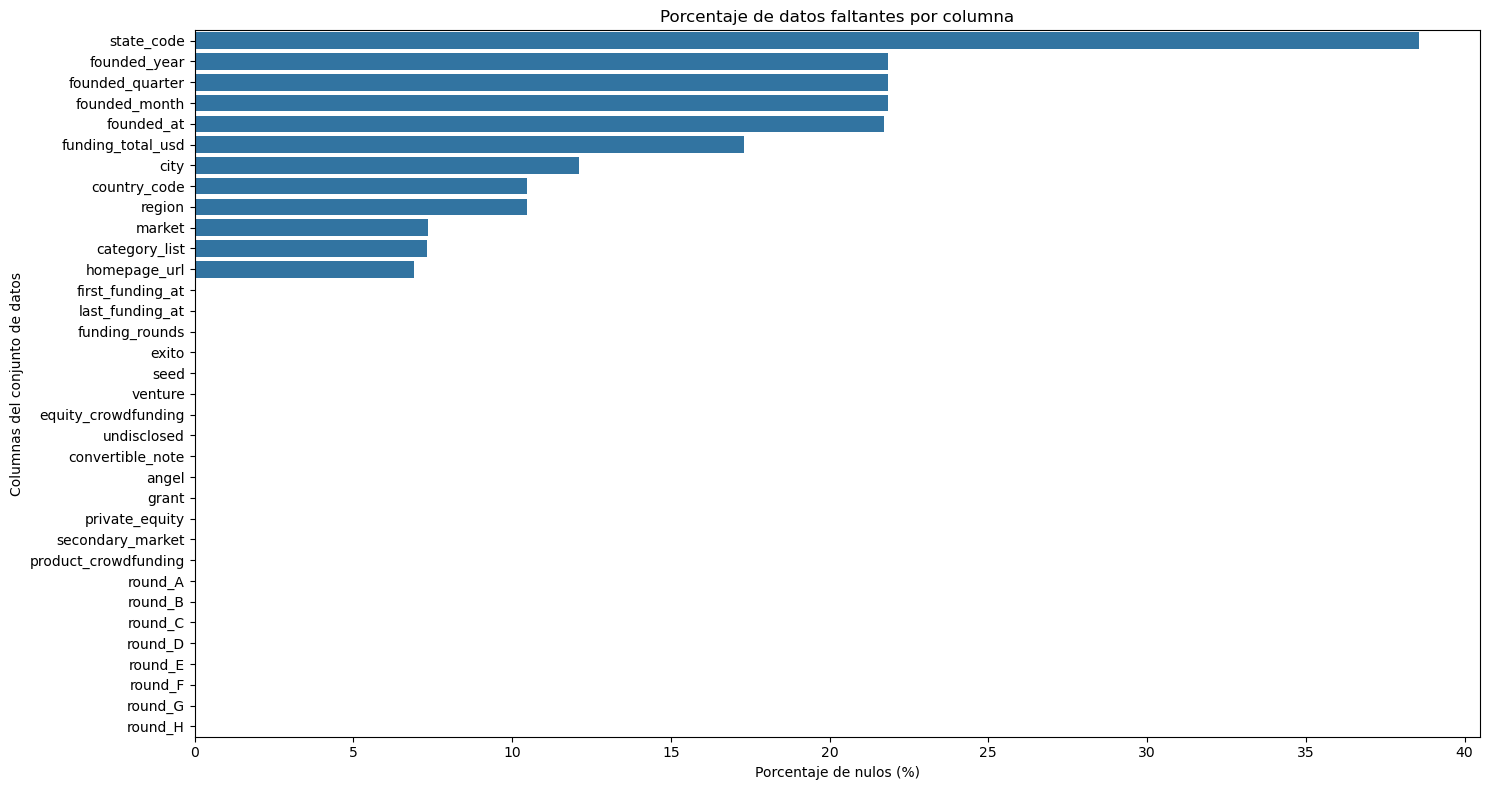

In [12]:
# 1. Calcular el n√∫mero de valores nulos por columna
valores_nulos = df.isnull().sum()

# 2. Calcular el porcentaje de valores nulos por columna
porcentaje_nulos = (valores_nulos / len(df)) * 100

# 3. Crear un DataFrame resumen con los datos faltantes
datos_faltantes = pd.DataFrame({
    'Columna': df.columns,
    'Valores nulos': valores_nulos,
    'Porcentaje de nulos (%)': porcentaje_nulos
}).sort_values(by='Porcentaje de nulos (%)', ascending=False)

# 4. Mostrar la tabla
print(datos_faltantes)

# 5. Visualizaci√≥n con Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x='Porcentaje de nulos (%)', y='Columna', data=datos_faltantes)
plt.title('Porcentaje de datos faltantes por columna')
plt.xlabel('Porcentaje de nulos (%)')
plt.ylabel('Columnas del conjunto de datos')
plt.tight_layout()
plt.show()

Se puede ver que la variable con mayor n√∫mero de datos faltantes est√° en `state_code`, lo que nos sugiere que muchos ejemplos no tienen dicha informaci√≥n, seguramente porque no son de Estados Unidos o son incompletos. `funding_total_usd` y `city` tambi√©n tienen un significativo n√∫mero de valores faltantes, lo que afecta al an√°lisis dependiente de la geograf√≠a y informaci√≥n financiera.

Por otro lado, `country_code` y `region` tienen una falta moderada de datos, lo que podr√≠a dificultar la segmentaci√≥n geogr√°fica o el an√°lisis de mercado.

Las variables `market` y `category_list` tambi√©n tienen valores perdidos lo que podr√≠a afectar a los an√°lisis que se hagan relacionados con los tipos de industria.

Finalmente, hay variables en las que casi no hay valores perdidos como `Round_A`, `Round_B`, `seed`.

### Interpretaci√≥n

### Brechas en los Datos Geogr√°ficos  
La ausencia significativa de valores en las columnas ``state_code``, ``city``, ``country_code`` y ``region`` implica dificultades para realizar un an√°lisis geogr√°fico detallado. Esto puede deberse a que el conjunto de datos incluye empresas a nivel global, donde dicha informaci√≥n no siempre est√° disponible de forma uniforme. Sin embargo, esto **no representar√° un problema en nuestro an√°lisis**, ya que m√°s adelante, en la Parte 3, construiremos caracter√≠sticas geogr√°ficas basadas en conjuntos de datos adicionales.

### Brechas en Mercado y Categor√≠a  
La falta de datos en las columnas ``market`` y ``category_list`` puede dificultar los estudios espec√≠ficos por sector o industria, ya que se limita la comprensi√≥n del segmento en el que operan las empresas. **Tampoco supondr√° un problema para nuestro an√°lisis**, ya que posteriormente construiremos una caracter√≠stica basada en un mapeo industrial a partir de los datos de ``market`` y no utilizaremos la columna ``category_list``, ya que en el contexto del capital riesgo, solo la industria tiene un impacto significativo.

### Brechas en Financiaci√≥n  
Una de las columnas con mayor cantidad de datos faltantes es ``funding_total_usd``. Esto probablemente se deba a que muchas startups no han recibido financiaci√≥n, lo cual es bastante habitual, considerando que el capital riesgo es una industria altamente selectiva, y solo un peque√±o porcentaje de startups consigue financiaci√≥n.

Como se explic√≥ anteriormente, una variable clave para el an√°lisis es la columna ``status``, que es esencial para construir la variable objetivo. Las filas con valores vac√≠os en ``status`` son inutilizables y deben eliminarse. En cambio, para otras columnas, especialmente aquellas relacionadas con rondas de financiaci√≥n (como ``pre_seed``, ``seed``, ``round_A``), **se deben rellenar con ceros** en lugar de eliminarlas. Esto se debe a que un valor vac√≠o en una columna de financiaci√≥n no implica necesariamente que se deba descartar la fila: las rondas de financiaci√≥n siguen una secuencia cronol√≥gica, y una startup puede haber levantado solo una ronda ``pre_seed`` sin avanzar a rondas posteriores.


Podemos observar que las empresas de nuestros datos se fundaron entre 1902 y 2014

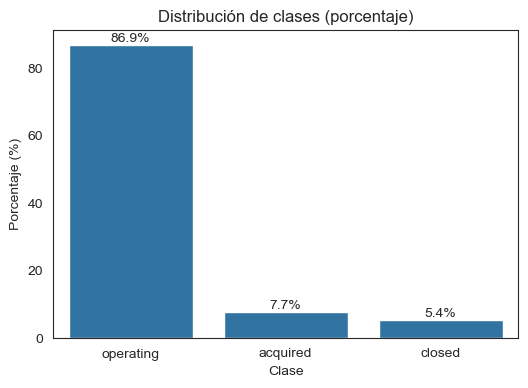

In [13]:
sns.set_style('white')
target = 'exito'


porcentajes = df[target].value_counts(normalize=True) * 100


plt.figure(figsize=(6,4))
ax = sns.barplot(x=porcentajes.index, y=porcentajes.values)
for i, v in enumerate(porcentajes.values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
ax.set_title("Distribuci√≥n de clases (porcentaje)")
ax.set_xlabel("Clase")
ax.set_ylabel("Porcentaje (%)")

plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

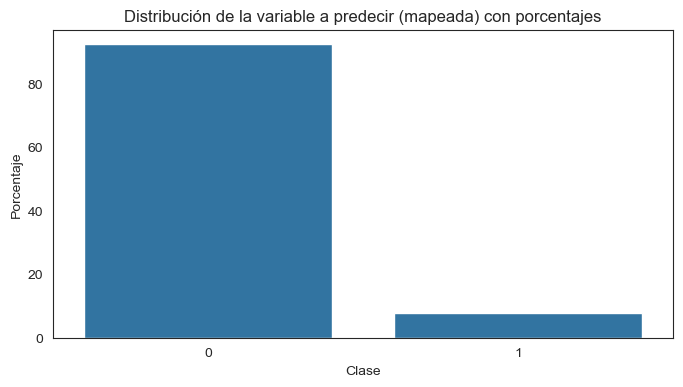

In [14]:
# target = 'exito'
# mapping = {'operating': 0, 'closed': 0, 'acquired': 1}
# df[target] = df[target].map(mapping)

# Calcular los porcentajes de cada clase en la variable 'exito'
# percentages = df[target].value_counts(normalize=True) * 100
mapping = {
    'acquired':  1,
    'closed':    0,
    'operating': 0,
    'ipo':       0
}
df['exito'] = df['exito'].map(mapping) \
                       .fillna(0) \
                       .astype(int)

# 2) Calcular porcentajes
percentages = df['exito'].value_counts(normalize=True) * 100 
# Crear el gr√°fico de barras con porcentajes
plt.figure(figsize=(8, 4))
sns.barplot(x=percentages.index, y=percentages.values)

# Configuraci√≥n del gr√°fico
plt.title('Distribuci√≥n de la variable a predecir (mapeada) con porcentajes')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')

plt.show

In [15]:
# Funci√≥n para agrupar por rangos
def year_group(row):
    year = row['founded_year'].year if pd.notnull(row['founded_year']) else None
    if year is None:
        return ''
    if 1900 <= year <= 1925:
        return 'less_than_1925'
    elif 1925 < year <= 1950:
        return '1925_1950'
    elif 1950 < year <= 1975:
        return '1950_1975'
    elif 1975 < year <= 2000:
        return '1975_2000'
    elif year > 2000:
        return '2000_2014'
    else:
        return ''

# Aplicar la funci√≥n
df['founded_year_group'] = df.apply(year_group, axis=1)

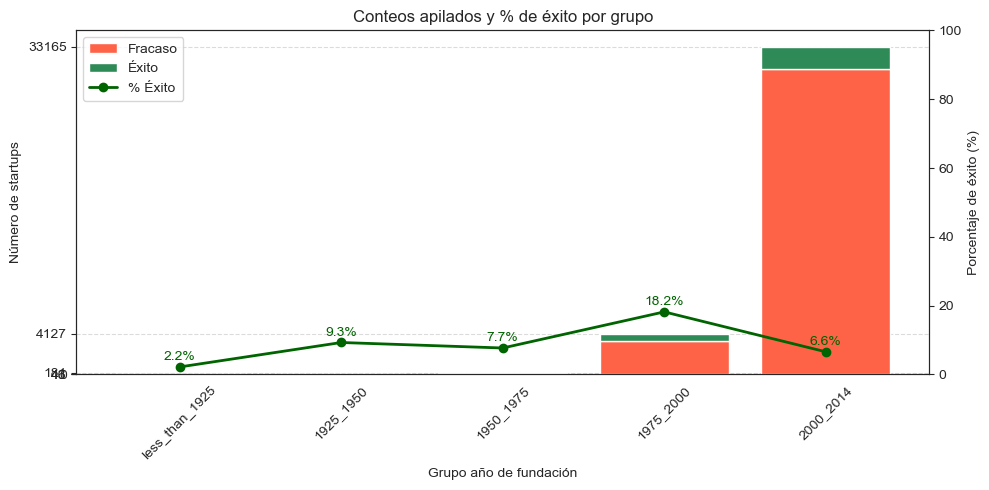

In [16]:
# 1) Preparar los datos
grouped = df.groupby('founded_year_group')['exito'].value_counts().unstack(fill_value=0)

ordered_groups = [
    'less_than_1925',
    '1925_1950',
    '1950_1975',
    '1975_2000',
    '2000_2014'
]

fails  = grouped.loc[ordered_groups, 0]
succs  = grouped.loc[ordered_groups, 1]
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)

# 2) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(10,5))

bar1 = ax1.bar(ordered_groups, fails,  label='Fracaso', color='tomato')
bar2 = ax1.bar(ordered_groups, succs, bottom=fails, label='√âxito',   color='seagreen')

# 3) Fijar los ticks del eje Y a los totales (y al 0)
yticks = np.concatenate([[0], totals.values])
ax1.set_yticks(sorted(yticks))
ax1.set_ylabel("N√∫mero de startups")
ax1.set_xlabel("Grupo a√±o de fundaci√≥n")
ax1.set_title("Conteos apilados y % de √©xito por grupo")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 4) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(ordered_groups, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% √âxito')
ax2.set_ylabel("Porcentaje de √©xito (%)")
ax2.set_ylim(0, 100)

# 5) Anotar % de √©xito encima de cada punto
for x, pct in zip(ordered_groups, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 6) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()


Se puede observar que casi todas las empresas se fundan entre el a√±o `2000` y `2014`. Por ello, ahora ploteamos la gr√°fica de solo los a√±os `2000` a `2014`.

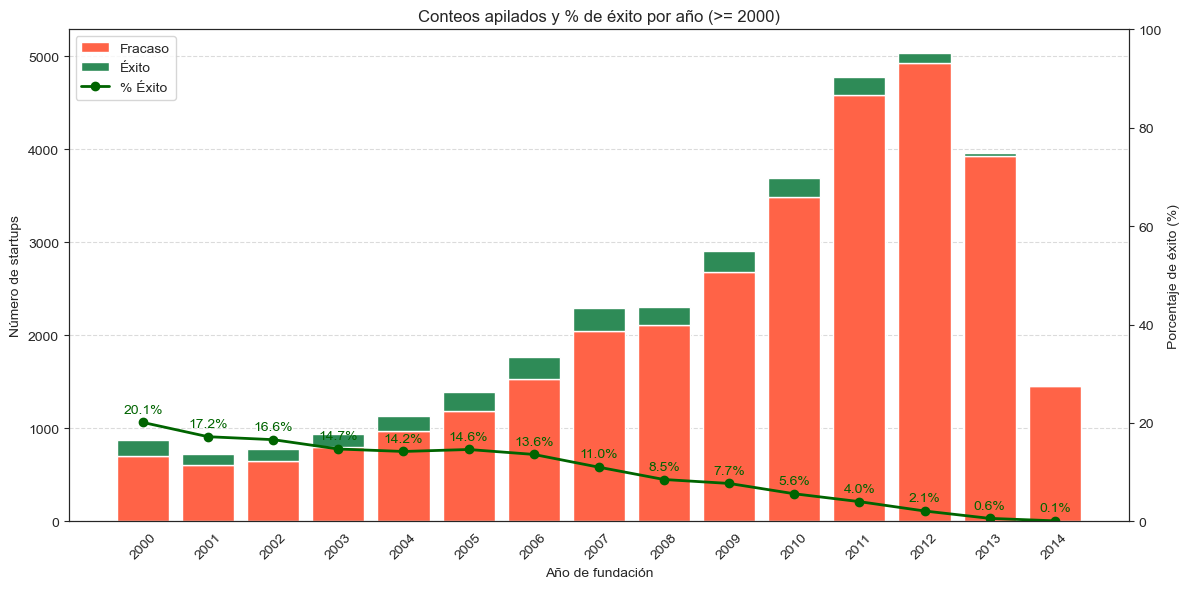

In [17]:
# 1) Filtrar los datos para a√±os de fundaci√≥n >= 2000
# Aseg√∫rate de que la columna est√° en formato datetime
df['founded_year'] = pd.to_datetime(df['founded_year'], errors='coerce')

# Filtrar usando el a√±o extra√≠do
df_new = df[df['founded_year'].dt.year >= 2000].copy()

# Convertir 'founded_year' a solo el a√±o como entero para graficar
df_new['founded_year'] = df_new['founded_year'].dt.year


# 2) Preparar los datos agrupados por a√±o de fundaci√≥n
grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

fails = grouped.get(0, pd.Series(dtype=int))
succs = grouped.get(1, pd.Series(dtype=int))
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)
years = grouped.index.tolist()

# 3) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
bar2 = ax1.bar(years, succs, bottom=fails, label='√âxito', color='seagreen')

# 4) Fijar las etiquetas del eje X a todos los a√±os
ax1.set_xticks(years)
ax1.set_ylabel("N√∫mero de startups")
ax1.set_xlabel("A√±o de fundaci√≥n")
ax1.set_title("Conteos apilados y % de √©xito por a√±o (>= 2000)")
ax1.tick_params(axis='x', rotation=45)

# El eje Y ahora usar√° los ticks predeterminados de Matplotlib
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 5) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% √âxito')
ax2.set_ylabel("Porcentaje de √©xito (%)")
ax2.set_ylim(0, 100)

# 6) Anotar % de √©xito encima de cada punto
for x, pct in zip(years, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 7) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

Sin embargo, el intervalo de tiempo en el que las empresas tienen mayor √©xito (en proporci√≥n) es entre `1975` y el a√±o `2000`, por lo que mostramos tambi√©n su gr√°fica.

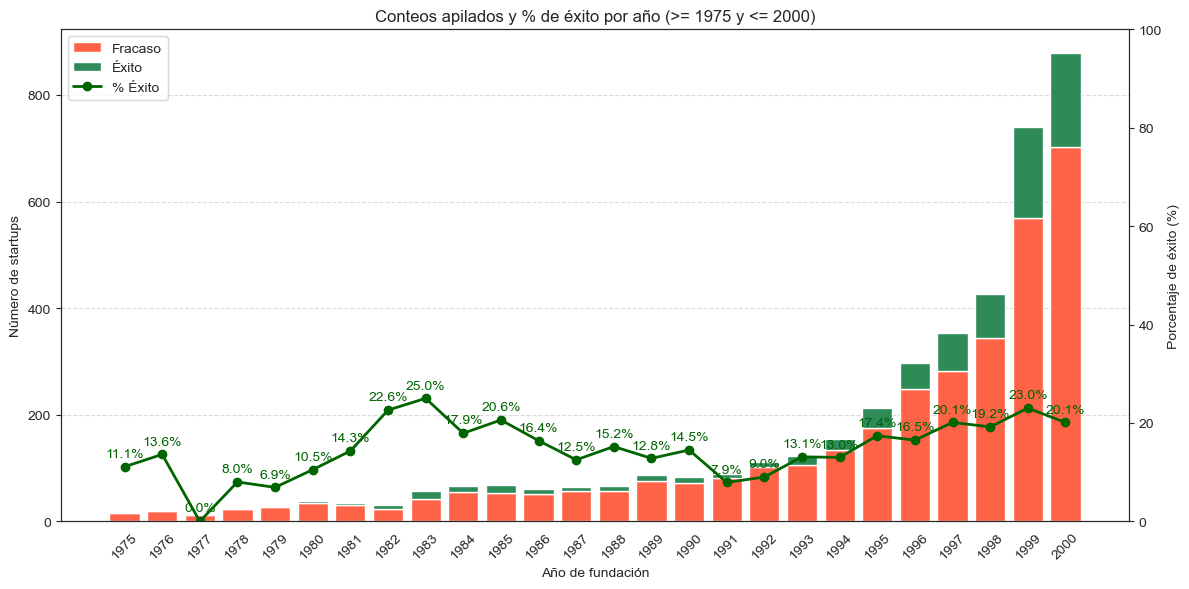

In [18]:
# 1) Filtrar los datos para a√±os de fundaci√≥n >= 2000
# Aseg√∫rate de que 'founded_year' est√° en formato datetime
df['founded_year'] = pd.to_datetime(df['founded_year'], errors='coerce')

# Extrae el a√±o como entero y filtra
df_new = df[
    (df['founded_year'].dt.year >= 1975) &
    (df['founded_year'].dt.year <= 2000)
].copy()

# Crea la nueva columna como enteros para graficar
df_new['founded_year'] = df_new['founded_year'].dt.year

# 2) Preparar los datos agrupados por a√±o de fundaci√≥n
grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

fails = grouped.get(0, pd.Series(dtype=int))
succs = grouped.get(1, pd.Series(dtype=int))
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)
years = grouped.index.tolist()

# 3) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
bar2 = ax1.bar(years, succs, bottom=fails, label='√âxito', color='seagreen')

# 4) Fijar las etiquetas del eje X a todos los a√±os
ax1.set_xticks(years)
ax1.set_ylabel("N√∫mero de startups")
ax1.set_xlabel("A√±o de fundaci√≥n")
ax1.set_title("Conteos apilados y % de √©xito por a√±o (>= 1975 y <= 2000)")
ax1.tick_params(axis='x', rotation=45)

# El eje Y ahora usar√° los ticks predeterminados de Matplotlib
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 5) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% √âxito')
ax2.set_ylabel("Porcentaje de √©xito (%)")
ax2.set_ylim(0, 100)

# 6) Anotar % de √©xito encima de cada punto
for x, pct in zip(years, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 7) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

### An√°lisis de la intensidad de financiaci√≥n

En este bloque de c√≥digo vamos a explorar c√≥mo el monto total de financiaci√≥n recibido por cada startup se relaciona con su probabilidad de √©xito:

1. **Discretizaci√≥n en intervalos**  
   - Definimos una serie de rangos (bins) que agrupan las startups seg√∫n franjas de inversi√≥n (por ejemplo, `<100K`, `100K‚Äì1M`, etc.).

2. **C√°lculo de √©xitos y fracasos**  
   - Agrupamos el n√∫mero de startups adquiridas (`exito = 1`) y no adquiridas (`exito = 0`) en cada intervalo.

3. **Visualizaci√≥n**  
   - Generamos un gr√°fico de barras **apiladas** para mostrar el conteo de √©xitos y fracasos por intervalo.  
   - Sobre el mismo eje, trazamos una **l√≠nea** que indica el porcentaje de √©xito dentro de cada rango de financiaci√≥n.

Este an√°lisis nos ayuda a identificar de manera intuitiva si existe alg√∫n umbral de inversi√≥n por encima del cual las startups muestran una mayor probabilidad de ser adquiridas.


C:\Users\marti\AppData\Local\Temp\ipykernel_3848\2200369026.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('fnd_bin')['exito']


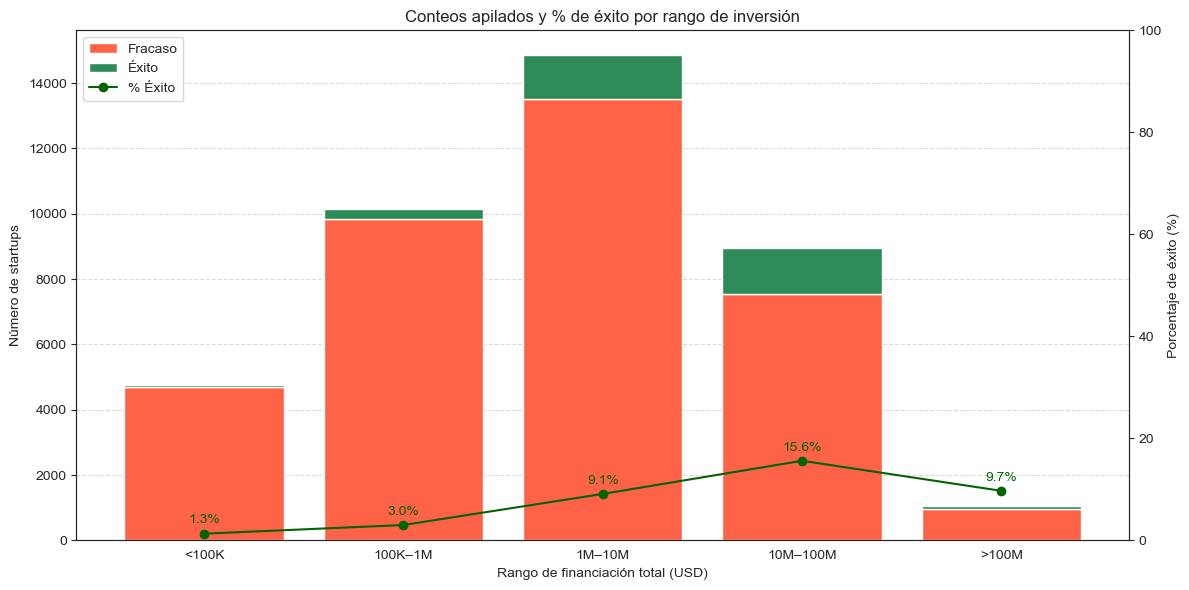

In [19]:
# 1) LIMPIEZA Y CONVERSI√ìN de funding_total_usd
df['funding_total_usd'] = (
    df['funding_total_usd']
      .astype(str)
      .str.replace(',', '', regex=False)
)
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')
df = df.dropna(subset=['funding_total_usd']).copy()

# 2) DEFINIR BINS Y ETIQUETAS
bins = [0, 1e5, 1e6, 1e7, 1e8, df['funding_total_usd'].max()]
labels = ['<100K', '100K‚Äì1M', '1M‚Äì10M', '10M‚Äì100M', '>100M']
df['fnd_bin'] = pd.cut(
    df['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 3) AGRUPAR √âXITOS/FRACASOS (**sin volver a remapear exito**)
grouped = (
    df
    .groupby('fnd_bin')['exito']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(labels, fill_value=0)
)

fails = grouped[0]
succs = grouped[1]
totals = fails + succs
pct    = (succs / totals * 100).round(1).fillna(0)

# 4) PLOT Apilado + L√≠nea de %
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(labels, fails,  color='tomato',    label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='√âxito')
ax1.set_xlabel("Rango de financiaci√≥n total (USD)")
ax1.set_ylabel("N√∫mero de startups")
ax1.set_title("Conteos apilados y % de √©xito por rango de inversi√≥n")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% √âxito')
ax2.set_ylabel("Porcentaje de √©xito (%)")
ax2.set_ylim(0, 100)

for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_3848\1262155248.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('fnd_bin')['exito']


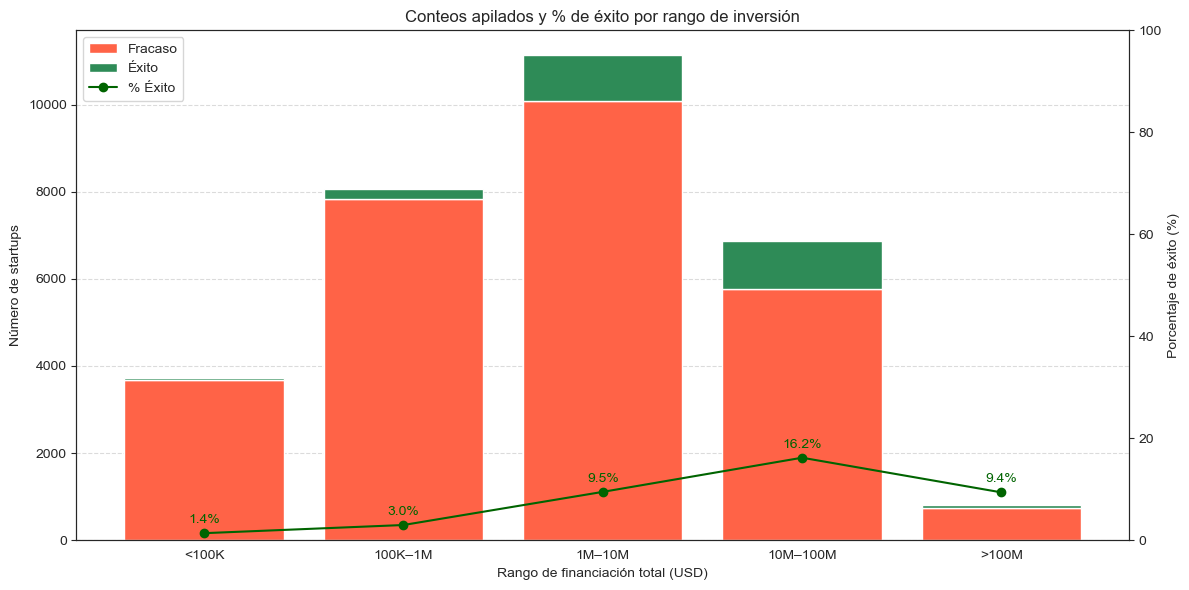

In [20]:
# Convertir a datetime (si a√∫n no lo has hecho)
df['founded_year'] = pd.to_datetime(df['founded_year'], errors='coerce')

# Crear una nueva columna con el a√±o como entero
df['founded_year_int'] = df['founded_year'].dt.year

# Filtrar usando el a√±o como entero
df = df[df['founded_year_int'] >= 1990].copy()

df = df.dropna(subset=['funding_total_usd']).copy()

# 2) DEFINIR BINS Y ETIQUETAS
bins = [0, 1e5, 1e6, 1e7, 1e8, df['funding_total_usd'].max()]
labels = ['<100K', '100K‚Äì1M', '1M‚Äì10M', '10M‚Äì100M', '>100M']

df['fnd_bin'] = pd.cut(
    df['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 3) AGRUPAR √âXITOS/FRACASOS y manejar valores ausentes
grouped = (
    df
    .groupby('fnd_bin')['exito']
    .value_counts()
    .unstack(fill_value=0)  # Asegura que los valores vac√≠os se rellenen con 0
)

# Reindexar para asegurarse de que todos los bins est√©n presentes, incluso si no hay datos para alguno
grouped = grouped.reindex(labels, fill_value=0)

# Ahora obtenemos las m√©tricas
fails = grouped[0]  # Fracasos
succs = grouped[1]  # √âxitos
totals = fails + succs  # Total de startups por bin
pct = (succs / totals * 100).round(1).fillna(0)  # Porcentaje de √©xito

# 4) PLOT Apilado + L√≠nea de %
fig, ax1 = plt.subplots(figsize=(12, 6))

# Crear gr√°fico apilado
ax1.bar(labels, fails, color='tomato', label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='√âxito')
ax1.set_xlabel("Rango de financiaci√≥n total (USD)")
ax1.set_ylabel("N√∫mero de startups")
ax1.set_title("Conteos apilados y % de √©xito por rango de inversi√≥n")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Crear el eje para la l√≠nea de porcentaje
ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% √âxito')
ax2.set_ylabel("Porcentaje de √©xito (%)")
ax2.set_ylim(0, 100)

# A√±adir etiquetas de porcentaje sobre la l√≠nea
for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

# Unir las leyendas de ambos gr√°ficos
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

# Ajustar el dise√±o para evitar superposiciones
plt.tight_layout()
plt.show()


### Impacto del n√∫mero de rondas de financiaci√≥n

Este gr√°fico muestra c√≥mo el n√∫mero de rondas de financiaci√≥n influye en la probabilidad de adquisici√≥n:

1. **Conteos apilados**  
   - Barras rojas (`Fracaso`): startups no adquiridas.  
   - Barras verdes (`√âxito`): startups adquiridas.  

2. **Porcentaje de √©xito**  
   - L√≠nea y marcadores en verde oscuro indican el porcentaje de startups adquiridas por cada n√∫mero de rondas.  

Con este an√°lisis podemos ver si m√°s rondas de financiaci√≥n se traducen en una mayor tasa de adquisiciones.  


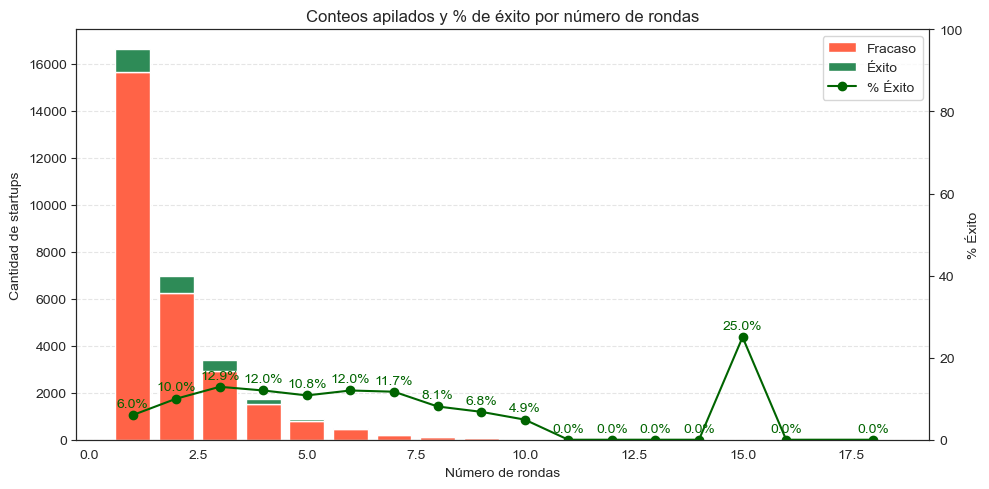

In [21]:
# 1) Agrupamos por n√∫mero de rondas y exito
grp2 = (
    df.groupby('funding_rounds')['exito']
      .value_counts()
      .unstack(fill_value=0)
      .sort_index()
)
fails2 = grp2.get(0, pd.Series(dtype=int))
succs2 = grp2.get(1, pd.Series(dtype=int))
rnds   = fails2.index
tot2   = fails2 + succs2
pct2   = (succs2 / tot2 * 100).round(1)

# 2) Plot
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(rnds, fails2,  color='tomato',    label='Fracaso')
ax1.bar(rnds, succs2, bottom=fails2, color='seagreen', label='√âxito')
ax1.set_xlabel("N√∫mero de rondas")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("Conteos apilados y % de √©xito por n√∫mero de rondas")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(rnds, pct2, color='darkgreen', marker='o', label='% √âxito')
ax2.set_ylabel("% √âxito")
ax2.set_ylim(0,100)

for x, p in zip(rnds, pct2):
    ax2.text(x, p+2, f"{p}%", ha='center', color='darkgreen')

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.tight_layout()
plt.show()


### Combinaci√≥n Sector‚ÄìPa√≠s (Top 5√óTop 5)

Este gr√°fico muestra c√≥mo se distribuyen las startups en los 5 sectores m√°s frecuentes y los 5 pa√≠ses principales:

1. **Barras apiladas**  
   - Cada barra representa un sector.  
   - Los segmentos apilados (colores) corresponden al n√∫mero de startups en cada pa√≠s.  

2. **L√≠nea de porcentaje de √©xito**  
   - L√≠nea negra con marcadores muestra el porcentaje medio de adquisiciones por sector, considerando todos los pa√≠ses.  

Este an√°lisis permite ver, de un vistazo, en qu√© combinaciones sector‚Äìpa√≠s se concentra el mayor volumen de startups y cu√°les tienen la mayor tasa de √©xito.  


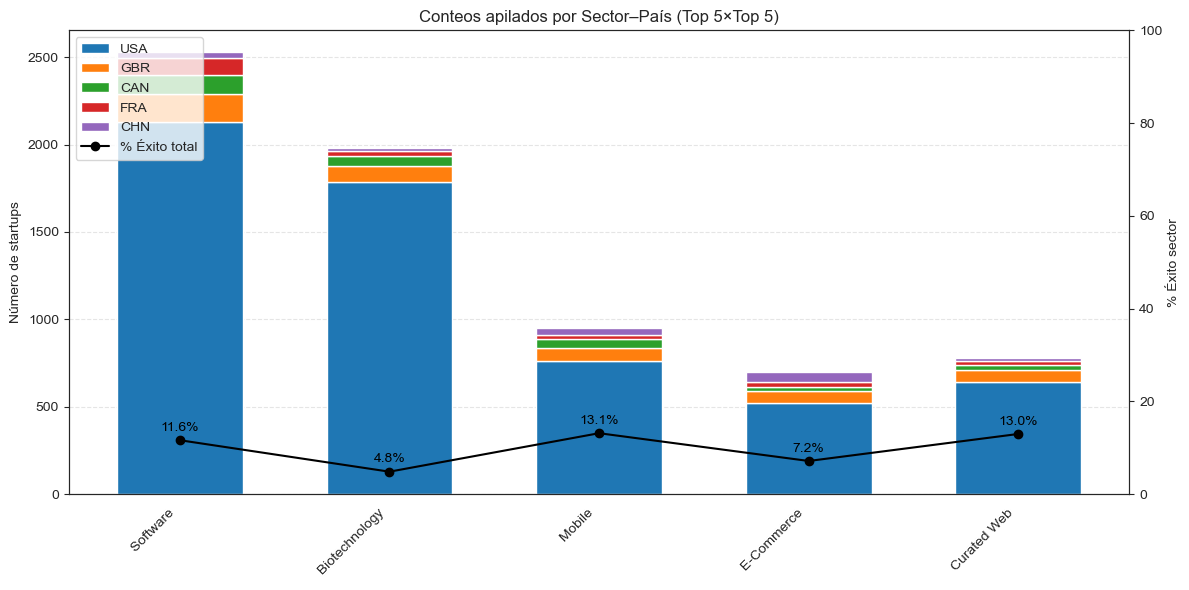

In [22]:
# 1) Filtramos top 5 de cada uno
top_secures   = df['market'].value_counts().head(5).index
top_countries = df['country_code'].value_counts().head(5).index
sub = df[df['market'].isin(top_secures) & df['country_code'].isin(top_countries)]

# 2) Pivot counts y % √©xito
pivot_cnt = sub.pivot_table(
    index='market', columns='country_code', values='exito',
    aggfunc=['count','mean']
)
cnts = pivot_cnt['count']
pcts = (pivot_cnt['mean'] * 100).round(1)

# 3) Para cada sector dibujamos barras apiladas por pa√≠s y % l√≠nea
fig, ax1 = plt.subplots(figsize=(12,6))
width = 0.6
x = np.arange(len(top_secures))

# apilado
bottom = np.zeros(len(top_secures))
for c in top_countries:
    vals = cnts[c].reindex(top_secures).fillna(0)
    ax1.bar(x, vals, width, bottom=bottom, label=c)
    bottom += vals

ax1.set_xticks(x)
ax1.set_xticklabels(top_secures, rotation=45, ha='right')
ax1.set_ylabel("N√∫mero de startups")
ax1.set_title("Conteos apilados por Sector‚ÄìPa√≠s (Top 5√óTop 5)")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# l√≠nea de % √©xito promedio por sector (sobre todos los pa√≠ses)
avg_pct = sub.groupby('market')['exito'].mean().reindex(top_secures) * 100
ax2 = ax1.twinx()
ax2.plot(x, avg_pct, color='black', marker='o', label='% √âxito total')
ax2.set_ylabel("% √âxito sector")
ax2.set_ylim(0,100)

for xi, p in zip(x, avg_pct):
    ax2.text(xi, p+2, f"{p:.1f}%", ha='center', color='black')

# leyenda combinada
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

plt.tight_layout()
plt.show()


### Top 25 Categor√≠as de Mercado y √âxito

Este gr√°fico muestra las **25 categor√≠as m√°s frecuentes** de startups y su **porcentaje de √©xito** (startups adquiridas):

1. **Barras**: representan el porcentaje de startups por categor√≠a.  
2. **Color secundario**: indica el porcentaje de √©xito en cada una.

Permite comparar la popularidad de cada categor√≠a con su tasa de adquisici√≥n.

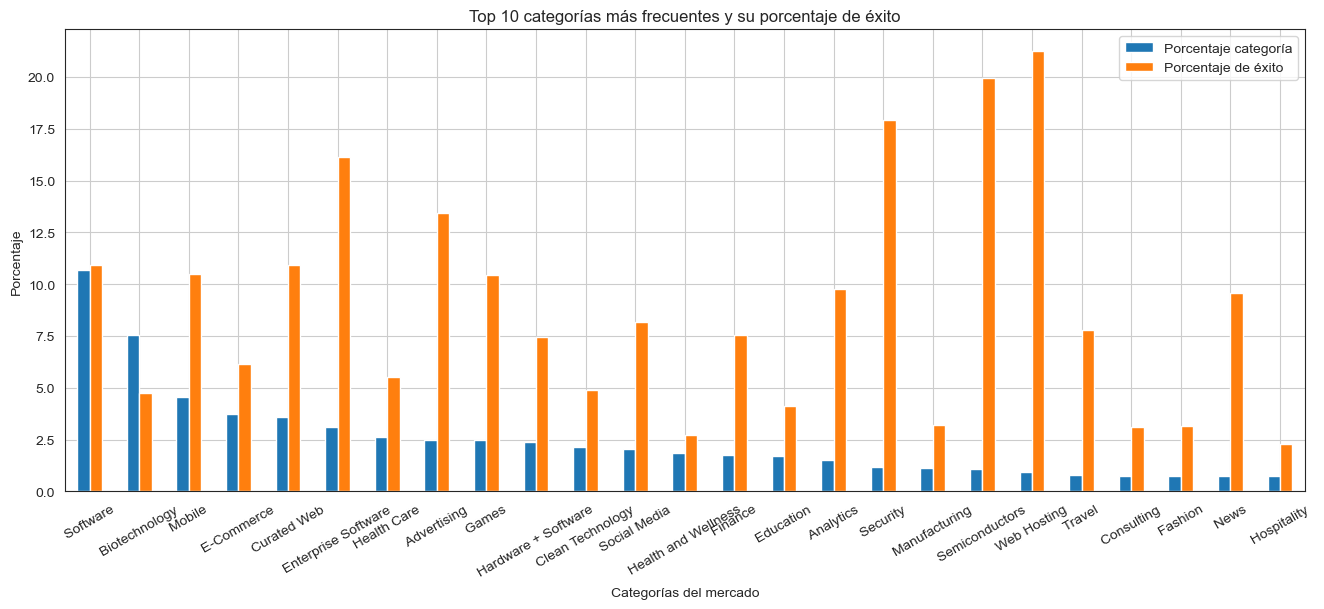

In [23]:
market_counts = df['market'].value_counts(normalize=True) * 100

# Calcular el porcentaje de 'exito = 1' para cada categor√≠a en 'market'
success_percentage = df.groupby('market')['exito'].mean() * 100

# Crear un DataFrame con los porcentajes de las categor√≠as y el porcentaje de √©xito
result_df = pd.DataFrame({
    'Porcentaje categor√≠a': market_counts,
    'Porcentaje de √©xito': success_percentage
})

# Seleccionar las 10 categor√≠as m√°s frecuentes
top_categories = market_counts.head(25)

# Filtrar el DataFrame resultante para mostrar solo las categor√≠as m√°s frecuentes
result_df_top = result_df.loc[top_categories.index]

# Graficar
result_df_top.plot(kind='bar', figsize=(16, 6))

plt.title('Top 10 categor√≠as m√°s frecuentes y su porcentaje de √©xito')
plt.xlabel('Categor√≠as del mercado')
plt.ylabel('Porcentaje')
plt.xticks(rotation=30)
plt.grid()
plt.show()

Se puede observar que el n√∫mero de startups **aumenta** cada a√±o.

C:\Users\marti\AppData\Local\Temp\ipykernel_3848\641170365.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100


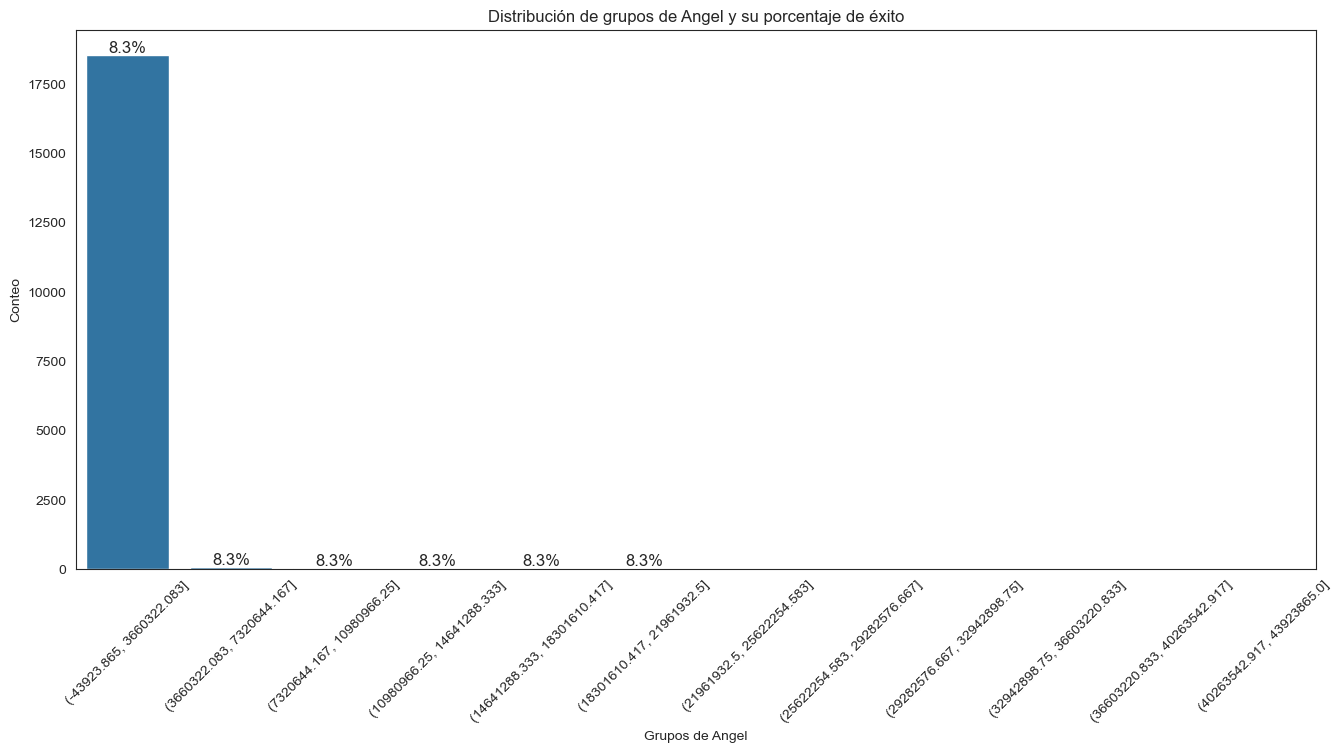

In [24]:
# Dividir la variable 'angel' en 12 grupos utilizando pd.cut
df['angel_group'] = pd.cut(df['angel'], bins=12)

# Calcular el porcentaje de 'exito = 1' para cada grupo en 'angel_group'
success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100

# Graficar la distribuci√≥n de 'angel_group'
plt.figure(figsize=(16, 7))

# Gr√°fico de barras con el conteo de cada grupo en 'angel_group'
sns.countplot(x='angel_group', data=df.dropna())

# A√±adir los porcentajes de √©xito encima de las barras
for p in plt.gca().patches:
    height = p.get_height()
    # Obtener el grupo de 'angel_group' correspondiente
    group_label = p.get_x() + p.get_width() / 2
    group_label = df['angel_group'].iloc[int(group_label)]  # Identificar la categor√≠a por √≠ndice
    
    # A√±adir el texto con el porcentaje de √©xito en el gr√°fico
    plt.text(p.get_x() + p.get_width() / 2, height + 1, f'{success_percentage_angel_group[group_label]:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Distribuci√≥n de grupos de Angel y su porcentaje de √©xito')
plt.xlabel('Grupos de Angel')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()


Podemos observar que casi todas las startups son de `Software` y `Biotechnology`, seguidas de `Mobile`,`E-Commerce` y `Curated Webs`.

Realizamos un an√°lisis de la variable a predecir en este caso, exito.

De momento vamos a asignar, la clase 1 a acquired y 0 a closed. Pero podr√≠amos realizar otra distribuci√≥n de clases si fuera de inter√©s para el trabajo

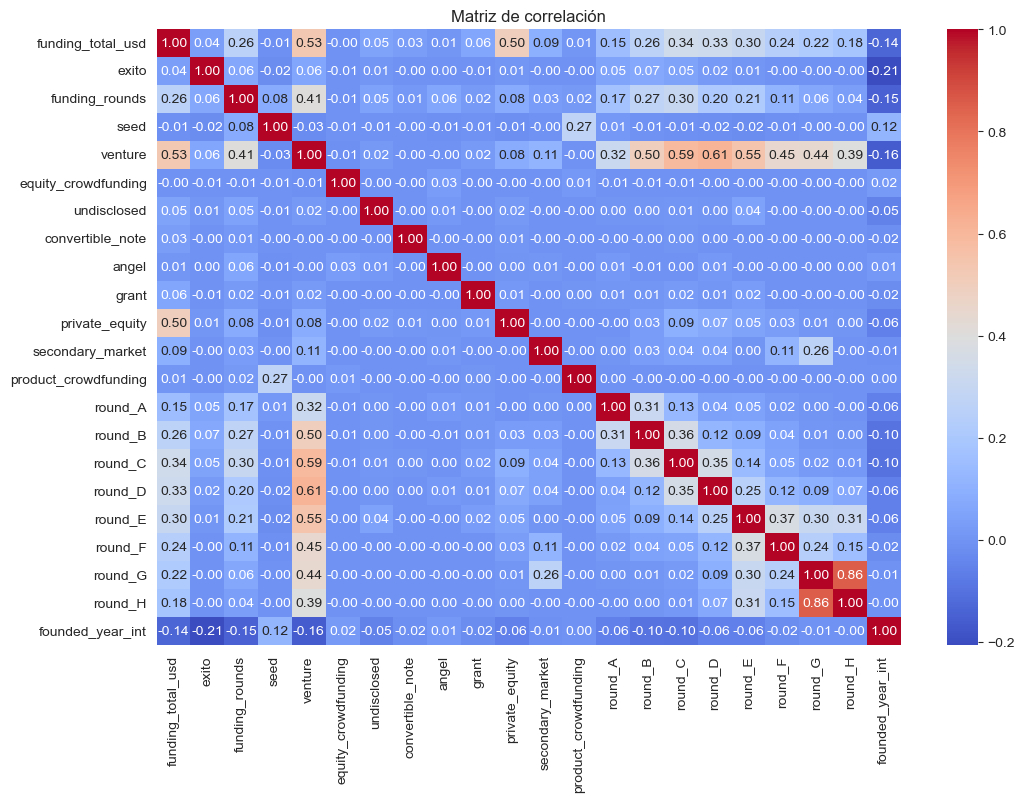

In [25]:
# Creamos una matriz de correlaci√≥n entre las variables num√©ricas
numerical_df = df.select_dtypes(include=['number']) 
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlaci√≥n')
plt.show()

Text(0.5, 1.0, 'Relaci√≥n entre funding_rounds, founded_year y exito')

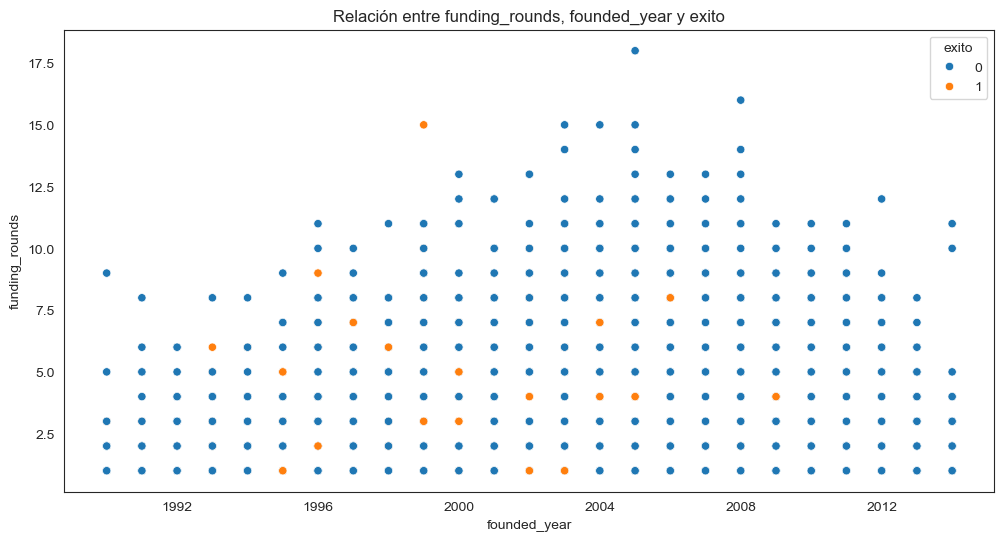

In [26]:
# Observamos que variables que est√°n m√°s correlacionadas con la variable de salida son funding_round y founded_year
# Observamos relacion entre funding_round, founded_year y variable objetivo 
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='founded_year', y='funding_rounds', hue='exito')
plt.title('Relaci√≥n entre funding_rounds, founded_year y exito')

M√°s rondas de financiaci√≥n aumentan la probabilidad de salida: Las startups con m√°s rondas de financiaci√≥n (4 o m√°s) tienen mayor probabilidad de ser "adquiridas" o "cerradas" en comparaci√≥n con aquellas con menos rondas (1-3), que suelen estar "operando". Esto sugiere que una financiaci√≥n sostenida aumenta las posibilidades de un evento de salida.

C:\Users\marti\AppData\Local\Temp\ipykernel_3848\3909155556.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_rounds = df.groupby(['funding_rounds_bin', 'exito']).size().unstack().fillna(0)


<Figure size 1000x600 with 0 Axes>

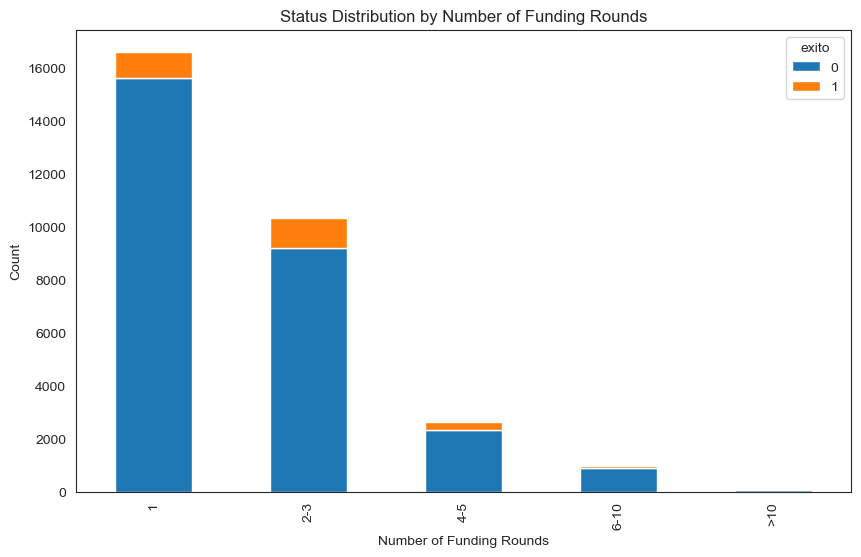

In [27]:
# Relationship 1: More Funding Rounds Increase Exit Likelihood
plt.figure(figsize=(10, 6))
df['funding_rounds_bin'] = pd.cut(df['funding_rounds'], bins=[0, 1, 3, 5, 10, float('inf')],
                                 labels=['1', '2-3', '4-5', '6-10', '>10'])
status_rounds = df.groupby(['funding_rounds_bin', 'exito']).size().unstack().fillna(0)
status_rounds.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Status Distribution by Number of Funding Rounds')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Count')
plt.legend(title='exito')
plt.show()


Mayores cantidades de financiaci√≥n se correlacionan con adquisiciones: Las startups adquiridas tienen una mediana de financiaci√≥n m√°s alta ($10M) en comparaci√≥n con las cerradas y las que est√°n operando ($1M), lo que indica que m√°s financiaci√≥n aumenta la probabilidad de adquisici√≥n, mientras que menos financiaci√≥n puede llevar al cierre.

<Figure size 1000x600 with 0 Axes>

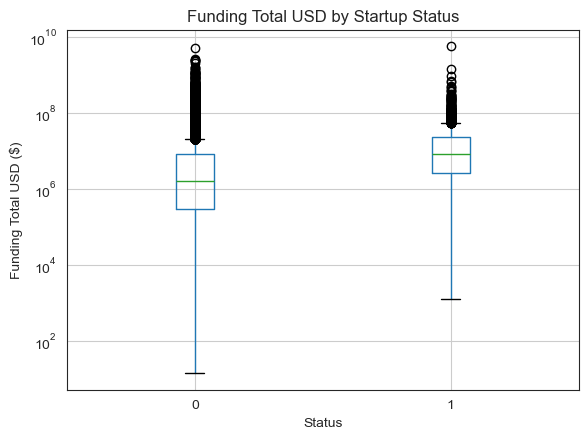

In [28]:
# Relationship 2: Higher Funding Amounts Correlate with Acquisitions
plt.figure(figsize=(10, 6))
df.boxplot(column='funding_total_usd', by='exito', showfliers=True)
plt.title('Funding Total USD by Startup Status')
plt.suptitle('')
plt.xlabel('Status')
plt.ylabel('Funding Total USD ($)')
plt.yscale('log')
plt.show()


La edad de la startup afecta su estado: Las startups m√°s nuevas (post-2010) est√°n mayormente "operando", mientras que las m√°s antiguas (pre-2005) tienen m√°s estados "adquiridas" y "cerradas". El per√≠odo 2005-2010 muestra una mezcla equilibrada, sugiriendo que 5-15 a√±os tras la fundaci√≥n es un per√≠odo cr√≠tico para salidas.


# Relationship 3: Startup Age Affects Status


Tendencias de financiaci√≥n a lo largo del tiempo: La financiaci√≥n total alcanz√≥ su pico alrededor de 2010-2015, reflejando un auge en la inversi√≥n en startups, mientras que el n√∫mero promedio de rondas de financiaci√≥n por startup se mantiene estable (1-2.5). Nota: Las tendencias antes de 1980 fueron excluidas debido a problemas de calidad de datos.

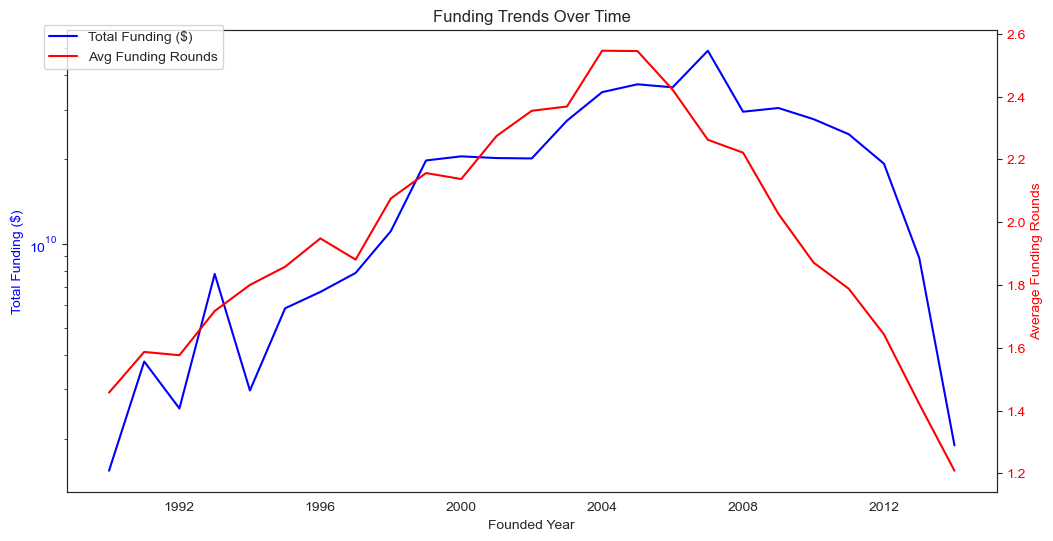

In [29]:

# Relationship 5: Funding Trends Over Time
df_yearly = df.groupby('founded_year').agg({
    'funding_total_usd': 'sum',
    'funding_rounds': 'mean'
}).reset_index()
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_yearly['founded_year'], df_yearly['funding_total_usd'], 'b-', label='Total Funding ($)')
ax1.set_xlabel('Founded Year')
ax1.set_ylabel('Total Funding ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.plot(df_yearly['founded_year'], df_yearly['funding_rounds'], 'r-', label='Avg Funding Rounds')
ax2.set_ylabel('Average Funding Rounds', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Funding Trends Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


## 4. Preparaci√≥n de los datos para clasificaci√≥n simple
Para poder realizar predicciones al principio, tenemos que lidiar con valores nulos primero realizaremos un analisis sencillo y los ignoraremos o sustituiremos, posteriormente usaremos tecnicas de imputacion y similares para intentar no perder informacion relevante.

Posteriormente aplicaremos una pipeline sencilla con knn para una primera clasificacion simple del problema

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

print("Valores √∫nicos en df['exito'] antes del mapeo:")
print(df['exito'].unique())
# Aseg√∫rate de partir del DataFrame correcto

X = df.drop(columns=['exito'])
y = df['exito']

# Separar columnas (ya tienes X definido)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5))
    ]), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Pipeline completa con Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
resultados = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline, beta=0.7)


Valores √∫nicos en df['exito'] antes del mapeo:
[1 0]
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.0309
AUC-PR:      0.2590


In [31]:
# === 1. Separar variables
X = df.drop(columns=['exito'])
y = df['exito']

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# === 3. Pipeline de preprocesamiento + modelo
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5))
    ]), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# === 4. Dividir el conjunto (hold-out 70/30)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# === 5. Ejecutar evaluaci√≥n
resultados = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)


==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1200
AUC-PR:      0.1563


### Limpiar data

Primero eliminamos las variables que sean creado para poder visualizar las gr√°ficas.

In [32]:
# Lista de las columnas de EDA que quieres eliminar
cols_to_drop = [
    'founded_year_group',
    'fnd_bin',
    'angel_group',
    'funding_rounds_bin'
]

# Opci√≥n A: borrarlas directamente del df original
df.drop(columns=cols_to_drop, inplace=True)

## 5. Imputaci√≥n de valores perdidos

In [33]:
# Divisi√≥n inicial: 60% entrenamiento, 40% restante
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Divisi√≥n secundaria: 50% validaci√≥n, 50% prueba del 40% restante
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Tama√±os de los conjuntos: \nEntrenamiento: {X_train.shape}, Validaci√≥n: {X_val.shape}, Prueba: {X_test.shape}")

Tama√±os de los conjuntos: 
Entrenamiento: (18380, 38), Validaci√≥n: (6127, 38), Prueba: (6127, 38)


### Imputaci√≥n de ``founded_year`` usando KNNImputer

#### Elecci√≥n de la imputaci√≥n frente a la eliminaci√≥n de valores

En nuestro conjunto de datos, la columna ``founded_year`` contiene m√°s de 10.000 registros faltantes. Eliminar una cantidad tan significativa de filas podr√≠a suponer una gran p√©rdida de informaci√≥n y sesgar potencialmente el an√°lisis. Imputar estos valores, especialmente al tratarse de a√±os, es una decisi√≥n razonable ya que preserva la integridad y el tama√±o del dataset.

#### ¬øPor qu√© usar KNNImputer?

Utilizamos ``KNNImputer`` porque permite estimar los a√±os faltantes considerando la similitud entre las observaciones. Este m√©todo parte de la suposici√≥n de que las empresas fundadas en a√±os cercanos pueden compartir caracter√≠sticas similares en otras variables, lo que convierte a KNN en una opci√≥n pr√°ctica para completar los valores ausentes de ``founded_year``.

#### Preparaci√≥n de los datos e imputaci√≥n

Antes de realizar la imputaci√≥n, la columna ``founded_year`` debe convertirse de tipo fecha a formato entero para cumplir con los requisitos de ``KNNImputer``. Luego, aplicamos la imputaci√≥n utilizando los vecinos m√°s cercanos, asegurando que nuestros datos sigan siendo consistentes y √∫tiles para el an√°lisis posterior.

In [34]:
print("Distribuci√≥n completa:", df['exito'].value_counts())

Distribuci√≥n completa: exito
0    28097
1     2537
Name: count, dtype: int64


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, precision_recall_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ========================
# 1. Dataset SIN imputaci√≥n
# ========================
df_base = df.copy()

X_base = df_base.drop(columns='exito')
y_base = df_base['exito']

num_cols = ['founded_year']
cat_cols = []  # puedes a√±adir categ√≥ricas si usas alguna

preprocessor_base = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline_base = ImbPipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [36]:
# ========================
# 2. Dataset CON imputaci√≥n KNN
# ========================
df_knn = df.copy()

# Convertir a datetime si no lo es
if not pd.api.types.is_datetime64_any_dtype(df_knn['founded_year']):
    df_knn['founded_year'] = pd.to_datetime(df_knn['founded_year'], errors='coerce', format='%Y')

print("After conversion, null values:", df_knn['founded_year'].isnull().sum())

# Extraer a√±o
df_knn['founded_year'] = df_knn['founded_year'].dt.year

# Imputaci√≥n KNN
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_knn['founded_year'] = imputer.fit_transform(df_knn[['founded_year']]).round()

print("Null values after imputation:", df_knn['founded_year'].isnull().sum())

# Rellenar otras columnas si es necesario
cols_fill_zero = [
    'convertible_note', 'angel', 'grant', 'private_equity',
    'secondary_market', 'product_crowdfunding', 'round_A','round_B',
    'round_C', 'round_D', 'round_E', 'round_F', 'round_G','round_H'
]
df_knn[cols_fill_zero] = df_knn[cols_fill_zero].fillna(0)

After conversion, null values: 0
Null values after imputation: 0


#### 5.1 Validaci√≥n

In [37]:
X_knn = df_knn.drop(columns='exito')
y_knn = df_knn['exito']

preprocessor_knn = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline_knn = ImbPipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
# ========================
# 3. Evaluaci√≥n
# ========================
puntuacion_sin_imputar = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline_base)
puntuacion_con_imputar = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline_knn)

print("Sin imputar:")
print(puntuacion_sin_imputar)

print("Con imputaci√≥n KNN:")
print(puntuacion_con_imputar)

==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1955
AUC-PR:      0.1723
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1955
AUC-PR:      0.1723
Sin imputar:
{'f_beta': np.float64(0.19551574623459606), 'AUC-PR': np.float64(0.17229121129911926)}
Con imputaci√≥n KNN:
{'f_beta': np.float64(0.19551574623459606), 'AUC-PR': np.float64(0.17229121129911926)}


## 6. Deteccion de outliers

### An√°lisis de valores at√≠picos

En esta parte nos centramos en analizar los **valores at√≠picos** dentro de las variables num√©ricas del dataset, especialmente aquellas que tienen que ver con las **rondas de financiaci√≥n**.

Para ello, usamos **boxplots** que nos permiten detectar de forma visual qu√© observaciones se alejan mucho del resto. Estos gr√°ficos son √∫tiles para hacernos una idea general de c√≥mo se distribuyen los datos y si hay valores extremos.

Sabemos que, en este tipo de datos, algunos outliers pueden ser simplemente **errores o datos mal introducidos**, pero otros pueden representar **casos reales pero extremos**, como startups que han recibido cantidades muy grandes de financiaci√≥n. Por eso, en vez de eliminar autom√°ticamente estos valores, decidimos evaluarlos seg√∫n el **contexto del problema**.

Este an√°lisis nos permite **decidir si eliminamos o ajustamos esos valores**, con el objetivo de que no distorsionen los modelos, pero sin perder informaci√≥n relevante. De esta forma, conseguimos que los datos con los que entrenamos los modelos sean m√°s fiables.


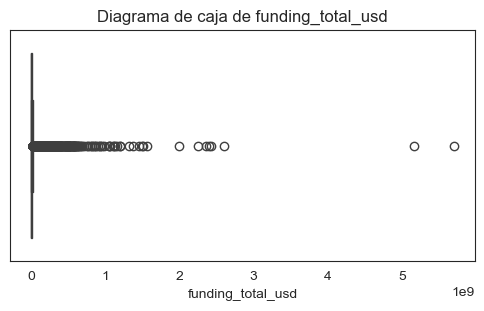

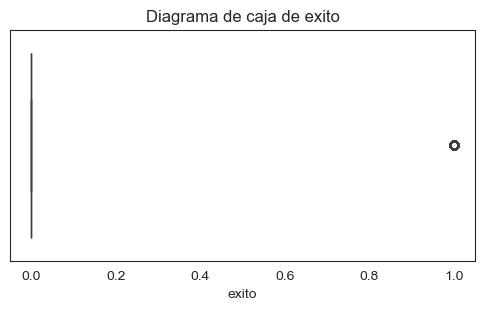

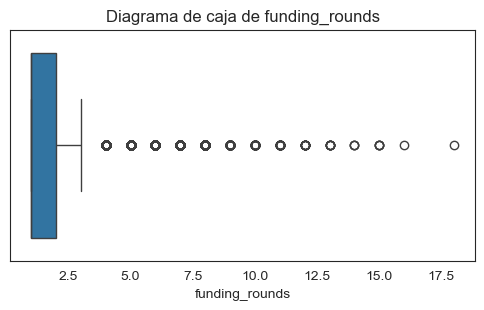

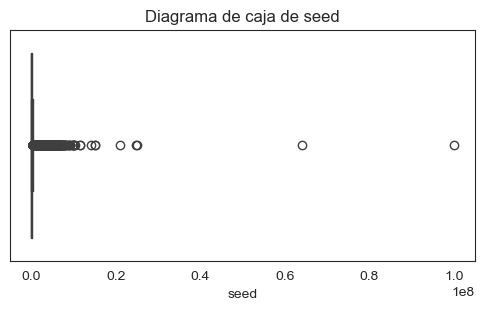

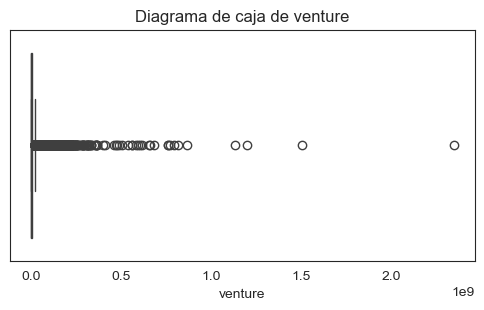

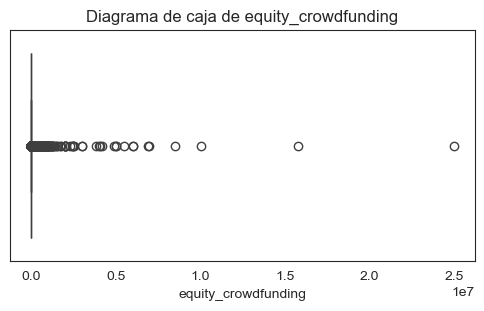

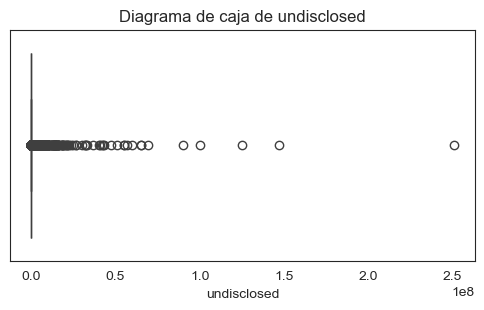

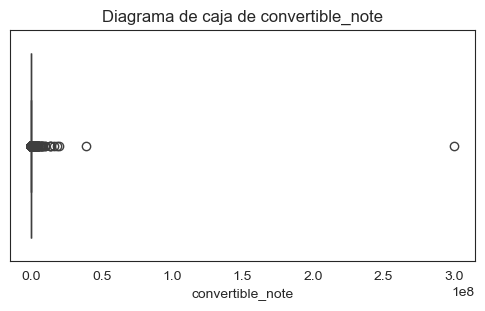

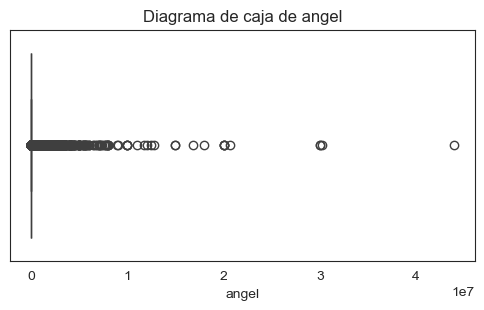

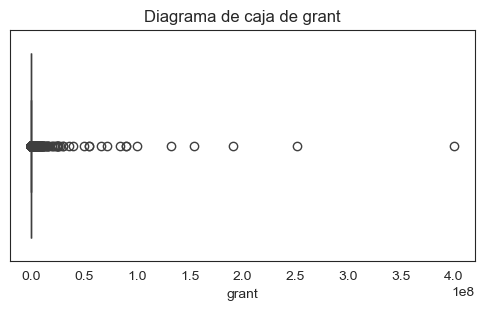

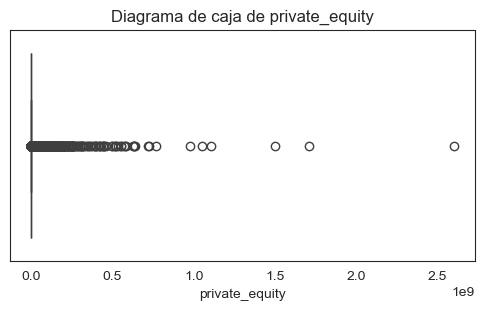

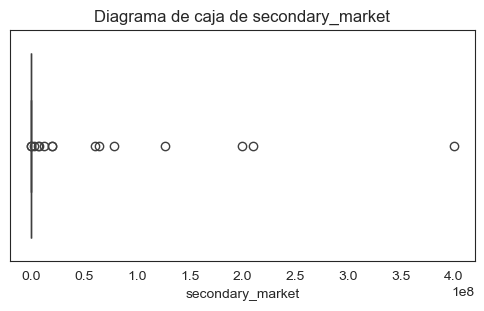

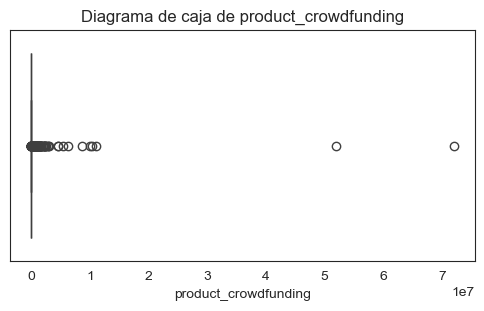

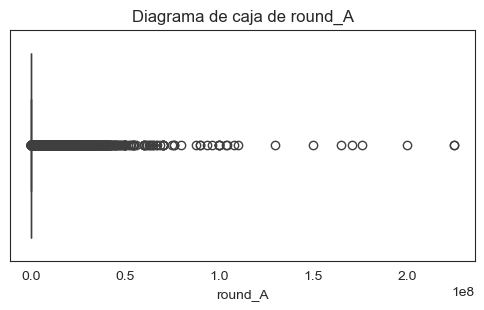

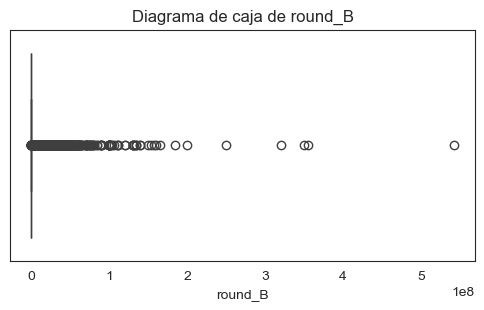

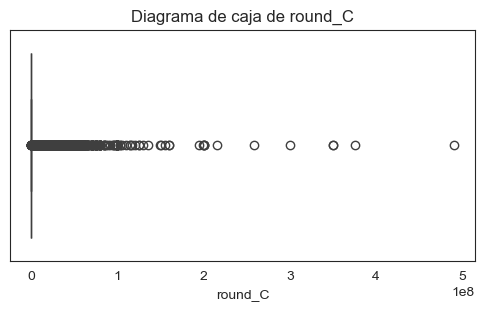

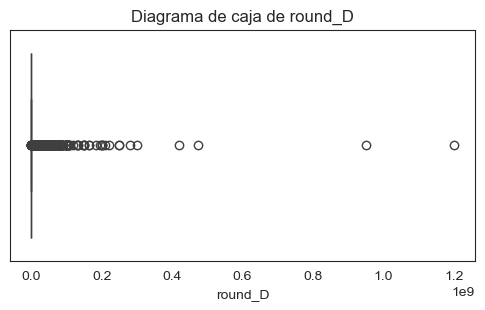

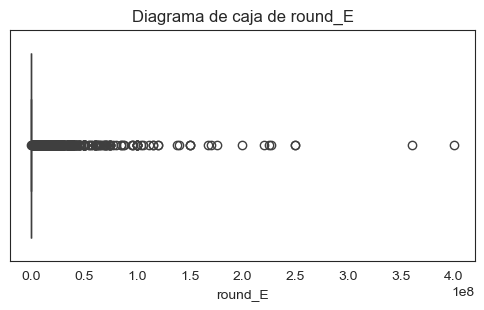

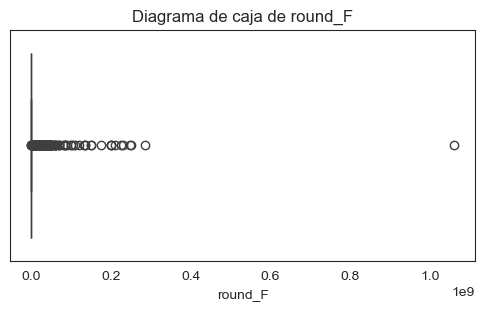

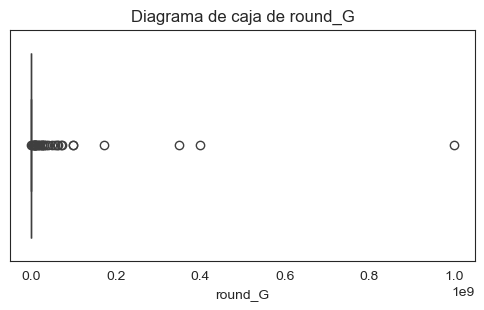

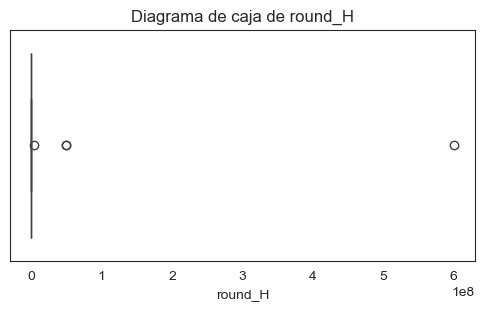

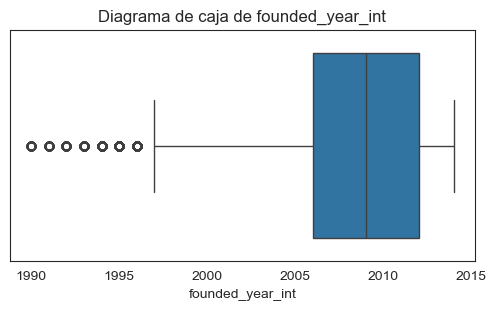

In [38]:
# Filtrar solo las columnas num√©ricas si es necesario
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

# Dibujar boxplots para cada variable num√©rica
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Diagrama de caja de {col}')
    plt.show()


### Observaciones a partir de los boxplots

Los **diagramas de caja** que generamos muestran una **asimetr√≠a considerable** en la distribuci√≥n de las variables de financiaci√≥n. En la mayor√≠a de los casos, los datos est√°n muy concentrados en valores bajos, mientras que hay una **cola larga** hacia la derecha, lo que sugiere la presencia de **outliers o valores extremos**.

Esta distribuci√≥n tan sesgada puede afectar negativamente al rendimiento de los modelos predictivos, ya que los algoritmos pueden verse influenciados por estos valores extremos.

Por eso, vamos a **revisar cada variable num√©rica por separado**, intentando entender qu√© est√° causando esa asimetr√≠a. En funci√≥n del an√°lisis, aplicaremos **transformaciones estad√≠sticas o t√©cnicas de normalizaci√≥n** que nos ayuden a reducir el sesgo.

El objetivo es que los datos est√©n en mejores condiciones para el modelado, lo que har√° que los resultados de los modelos sean m√°s **estables y fiables**.


### Buscamos variables relacionadas I

In [39]:
cutoffs = {
    'equity_crowdfunding': 3e6,       # Financiaci√≥n por crowdfunding de acciones ‚Üí 3 millones de d√≥lares
    'product_crowdfunding': 3e6,      # Financiaci√≥n por crowdfunding de productos ‚Üí 3 millones de d√≥lares
    'undisclosed': 20e6,              # Financiaci√≥n de origen no revelado ‚Üí 20 millones de d√≥lares
    'venture': 50e6,                  # Financiaci√≥n de capital riesgo ‚Üí 50 millones de d√≥lares
    'grant': 5e6,                     # Subvenciones ‚Üí 5 millones de d√≥lares
    'private_equity': 300e6,          # Capital privado ‚Üí 300 millones de d√≥lares
    'secondary_market': 100e6,        # Mercado secundario ‚Üí 100 millones de d√≥lares
    'convertible_note': 5e6,          # Notas convertibles ‚Üí 5 millones de d√≥lares
    'angel': 5e6,                     # Financiaci√≥n de inversores √°ngeles ‚Üí 5 millones de d√≥lares
    'seed': 10e6,                     # Ronda semilla ‚Üí 10 millones de d√≥lares
    'round_A': 20e6,                  # Serie A ‚Üí 20 millones de d√≥lares
    'round_B': 30e6,                  # Serie B ‚Üí 30 millones de d√≥lares
    'round_C': 40e6,                  # Serie C ‚Üí 40 millones de d√≥lares
    'round_D': 60e6,                  # Serie D ‚Üí 60 millones de d√≥lares
    'round_E': 80e6,                  # Serie E ‚Üí 80 millones de d√≥lares
    'round_F': 100e6,                 # Serie F ‚Üí 100 millones de d√≥lares
}
# Guardar el n√∫mero de filas original del conjunto de datos
original_data_count = df.shape[0]

# Aplicar los umbrales m√°ximos definidos para cada tipo de financiaci√≥n
# y filtrar las filas que superan dichos valores
for funding_type, cutoff in cutoffs.items():
    df = df[df[funding_type] <= cutoff]

# Mostrar informaci√≥n antes y despu√©s de eliminar los valores at√≠picos
print(f"Datos originales: {original_data_count} filas")
print(f"Forma del conjunto de datos tras eliminar los outliers de financiaci√≥n: {df.shape}")


Datos originales: 30634 filas
Forma del conjunto de datos tras eliminar los outliers de financiaci√≥n: (28708, 35)


### Justificaci√≥n de los umbrales aplicados

**Rondas iniciales (Seed, Angel, A, B, C):**  
Los l√≠mites establecidos para estas etapas tempranas reflejan las cantidades de financiaci√≥n que se observan con mayor frecuencia en startups en sus primeras fases. En este punto del desarrollo empresarial, las inversiones suelen ser m√°s moderadas, por lo que se han definido umbrales realistas que permiten descartar operaciones at√≠picamente altas y mantener el an√°lisis centrado en casos representativos.

**Rondas posteriores (D, E, F):**  
En etapas m√°s avanzadas, es habitual que las empresas necesiten mayores sumas para consolidar su crecimiento o expandirse a nuevos mercados. Por ello, los l√≠mites aplicados son m√°s altos y buscan capturar estos niveles de financiaci√≥n sin que algunas operaciones excepcionales influyan en exceso en el comportamiento general del conjunto de datos.

**Financiaci√≥n especializada (Private Equity, Crowdfunding, etc.):**  
Este tipo de financiaci√≥n presenta una gran variabilidad seg√∫n el sector o el contexto de inversi√≥n. Se han definido l√≠mites que permiten incluir una gran parte de los casos habituales, pero que al mismo tiempo filtran aquellas operaciones que se alejan significativamente de la norma y que podr√≠an distorsionar los resultados del an√°lisis.


In [40]:
from scipy import stats
# An√°lisis de valores at√≠picos (outliers) para la variable 'funding_rounds'

# Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
Q1_funding_rounds = df['funding_rounds'].quantile(0.25)
Q3_funding_rounds = df['funding_rounds'].quantile(0.75)
IQR_funding_rounds = Q3_funding_rounds - Q1_funding_rounds  # Rango intercuart√≠lico

# Definir outliers como aquellos que est√°n fuera de 1.5 * IQR por debajo de Q1 o por encima de Q3
outliers_IQR_funding_rounds = df[
    (df['funding_rounds'] < (Q1_funding_rounds - 1.5 * IQR_funding_rounds)) |
    (df['funding_rounds'] > (Q3_funding_rounds + 1.5 * IQR_funding_rounds))
]

# Calcular los Z-scores para detectar outliers extremos
z_scores_funding_rounds = np.abs(stats.zscore(df['funding_rounds']))
outliers_Z_funding_rounds = df[z_scores_funding_rounds > 3]

# Contar el n√∫mero de valores at√≠picos detectados por cada m√©todo
outliers_IQR_count_funding_rounds = outliers_IQR_funding_rounds.shape[0]
outliers_Z_count_funding_rounds = outliers_Z_funding_rounds.shape[0]

# Imprimir los resultados
print(f"N√∫mero de outliers detectados con el m√©todo IQR: {outliers_IQR_count_funding_rounds}")
print(f"N√∫mero de outliers detectados con el m√©todo Z-score: {outliers_Z_count_funding_rounds}")


N√∫mero de outliers detectados con el m√©todo IQR: 2636
N√∫mero de outliers detectados con el m√©todo Z-score: 573


C:\Users\marti\AppData\Local\Temp\ipykernel_3848\738668040.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=funding_rounds_counts.index, y=funding_rounds_counts.values, palette='viridis')


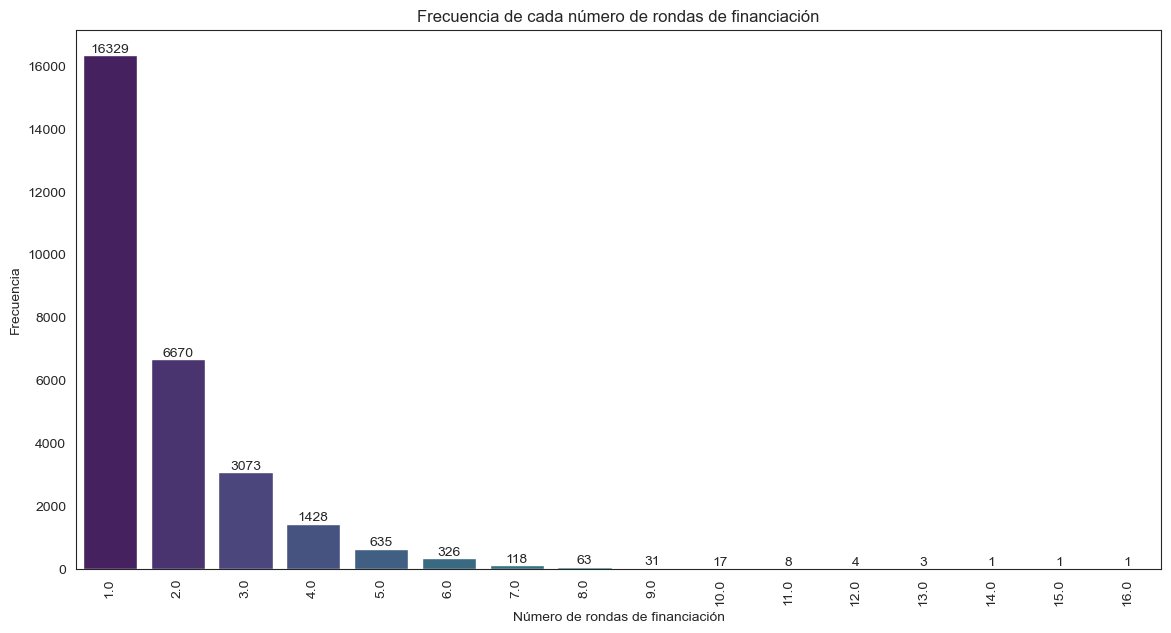

In [41]:
# Contar la frecuencia de cada n√∫mero de rondas de financiaci√≥n
funding_rounds_counts = df['funding_rounds'].value_counts().sort_index()

# Crear un gr√°fico de barras
plt.figure(figsize=(14, 7))
sns.barplot(x=funding_rounds_counts.index, y=funding_rounds_counts.values, palette='viridis')

# A√±adir anotaciones con los valores exactos
for i, count in enumerate(funding_rounds_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Frecuencia de cada n√∫mero de rondas de financiaci√≥n')
plt.xlabel('N√∫mero de rondas de financiaci√≥n')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotar etiquetas si se solapan
plt.show()


### Validaci√≥n

In [42]:
# === Aplicar eliminaci√≥n de outliers por IQR
df_iqr = df.copy()
q1 = df_iqr['funding_rounds'].quantile(0.25)
q3 = df_iqr['funding_rounds'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df_iqr = df_iqr[(df_iqr['funding_rounds'] >= lower) & (df_iqr['funding_rounds'] <= upper)]

# === Aplicar eliminaci√≥n de outliers por Z-score
df_z = df.copy()
z_scores = np.abs(stats.zscore(df_z['funding_rounds']))
df_z = df_z[z_scores <= 3]

# === Separar X e y
X_iqr = df_iqr.drop(columns='exito')
y_iqr = df_iqr['exito']
X_z = df_z.drop(columns='exito')
y_z = df_z['exito']

# === ColumnTransformer (sin funciones que eliminan filas)
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# === Pipelines
pipeline_iqr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline_z = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# === Split estratificado para cada conjunto
for intento in range(10):
    X_train_iqr, X_val_iqr, y_train_iqr, y_val_iqr = train_test_split(X_iqr, y_iqr, test_size=0.3, stratify=y_iqr, random_state=42+intento)
    if len(np.unique(y_train_iqr)) > 1: break

for intento in range(10):
    X_train_z, X_val_z, y_train_z, y_val_z = train_test_split(X_z, y_z, test_size=0.3, stratify=y_z, random_state=42+intento)
    if len(np.unique(y_train_z)) > 1: break

# === Evaluaci√≥n
print("üîç Evaluaci√≥n con IQR:")
resultado_iqr = evaluar_pipeline(X_train_iqr, y_train_iqr, X_val_iqr, y_val_iqr, pipeline_iqr)

print("\nüîç Evaluaci√≥n con Z-score:")
resultado_z = evaluar_pipeline(X_train_z, y_train_z, X_val_z, y_val_z, pipeline_z)


üîç Evaluaci√≥n con IQR:
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1828
AUC-PR:      0.1689

üîç Evaluaci√≥n con Z-score:
==== Evaluaci√≥n del modelo ====
F0.7-score: 0.1965
AUC-PR:      0.1882


### Criterio para limitar el n√∫mero de rondas de financiaci√≥n
Aunque el uso del IQR nos permitir√≠a eliminar valores extremos, este m√©todo podr√≠a descartar demasiados casos relevantes, especialmente aquellos con un n√∫mero razonable de rondas. Por eso, en lugar de aplicar un umbral estad√≠stico, optamos por eliminar √∫nicamente las startups que tienen m√°s de 10 rondas de financiaci√≥n.

Superar esta cifra suele ser poco habitual en el √°mbito del venture capital y puede reflejar dificultades prolongadas para alcanzar la rentabilidad o una necesidad extraordinaria de capital. Limitar el n√∫mero de rondas a un m√°ximo de 10 nos permite mantener el enfoque en trayectorias de inversi√≥n m√°s comunes y realistas, lo que mejora tanto la representatividad del conjunto de datos como la capacidad predictiva del modelo.

In [43]:
print("Tama√±o del conjunto de datos antes de eliminar outliers en funding_rounds:", df.shape)
df = df[df['funding_rounds'] <= 10]
print("Tama√±o del conjunto de datos despu√©s de eliminar outliers en funding_rounds:", df.shape)

Tama√±o del conjunto de datos antes de eliminar outliers en funding_rounds: (28708, 35)
Tama√±o del conjunto de datos despu√©s de eliminar outliers en funding_rounds: (28690, 35)


### Buscamos variables relacionadas II

<Axes: xlabel='founded_year', ylabel='Count'>

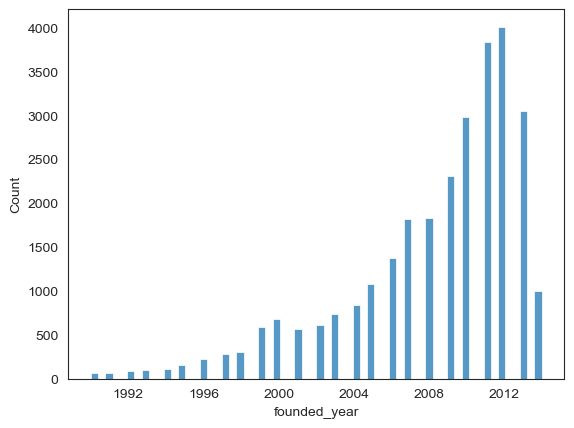

In [44]:
import seaborn as sns
sns.histplot(df['founded_year'].dropna(), kde=False)

In [47]:
print("Tama√±o del conjunto de datos antes de eliminar a√±os anteriores a 1990:", df.shape)

df = df[df['founded_year'] >= 1990]

print("Tama√±o del conjunto de datos despu√©s de eliminar a√±os anteriores a 1990:", df.shape)


Tama√±o del conjunto de datos antes de eliminar a√±os anteriores a 1990: (28690, 35)
Tama√±o del conjunto de datos despu√©s de eliminar a√±os anteriores a 1990: (0, 35)


In [ ]:
sns.histplot(df_clean['founded_year'].dropna(), kde=False)

## 7. Transformaci√≥n del tipo de variable

En primer lugar, antes de estandarizar los datos, nos tenemos que asegurar de que est√°n en su tipo correcto. Es por ello, por lo que primero hay que:
1. Transformar los tipos de datos que consideremos.
2. Imputar los valores perdidos

In [45]:
# Sobreescribe la original con el a√±o entero
df['founded_year'] = df['founded_year'].dt.year

# Ahora aplica pd.cut en l√≠nea sobre esa columna
df['founded_year'] = pd.cut(
    df['founded_year'],
    bins=[1900, 1925, 1950, 1975, 2000, 2015],
    labels=['1900‚Äì25','25‚Äì50','50‚Äì75','75‚Äì00','00‚Äì14'],
    include_lowest=True
)
df['founded_year'] = df['founded_year'].cat.codes.replace(-1, np.nan)


#### 6.1 Validaci√≥n

In [46]:
# 1) Quita 'founded_year' de numerical_cols (ya lo hiciste)
num_cols = [c for c in numerical_cols if c != 'founded_year']

# 2) Reconstruye el preprocesador usando 'founded_year_int'
preprocessor = ColumnTransformer([
    ('num',          num_imp,           num_cols),
    ('cat',          cat_pipe,          categorical_cols),
], remainder='drop')

# 3. El resto igual
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', KNeighborsClassifier())
])

# 4. Evaluar
scores = evaluar_pipeline(X, y, pipe, beta=0.7, test_size=0.2, random_state=42)
print(f"F‚ÇÄ.‚Çá = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")


NameError: name 'num_imp' is not defined

### Discretizaci√≥n de la variable `homepage_url`

La variable `homepage_url` indica si una startup tiene o no una p√°gina web registrada. Aunque su contenido es textual, su presencia puede reflejar cierto grado de profesionalizaci√≥n o visibilidad que favorece el √©xito de la start-up.

**Transformaci√≥n aplicada**:  
Se ha convertido en una variable binaria (`has_url`), con valor `1` si la URL est√° presente y `0` en caso contrario.

Esta transformaci√≥n permite incluir esta informaci√≥n como una caracter√≠stica √∫til en los modelos de clasificaci√≥n.


In [ ]:
df.head(10)

In [ ]:
# Crear variable binaria: 1 si tiene homepage_url, 0 si est√° vac√≠a o es NaN
df['homepage_url'] = df['homepage_url'].notna().astype(int)

#### 6.2 Validaci√≥n

In [ ]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import OrdinalEncoder

# 0) Definir los distintos encoders que vas a probar
categorical_encoders = {
    'onehot':  OneHotEncoder(handle_unknown='ignore', sparse_output=False),
    'ordinal': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'target':  TargetEncoder()
}

results = []
for enc_name, encoder in categorical_encoders.items():
    print(f"\n--- Evaluating {enc_name} encoder with has_url ---")

    # Build the preprocessing+classifier pipeline
    num_imp = numeric_imputers[best_numeric_imp]
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
        ('enc', encoder)
    ])
    preprocessor = ColumnTransformer([
        ('num', num_imp, numerical_cols),        # Ahora incluye 'has_url'
        ('cat', cat_pipe, categorical_cols)
    ], remainder='drop')

    pipe = Pipeline([
        ('pre', preprocessor),
        ('clf', KNeighborsClassifier())
    ])

    scores = evaluar_pipeline(X_val, y_val, pipe, beta=0.7, test_size=0.2, random_state=42)
    print(f"{enc_name:7s} ‚Üí f‚ÇÅ = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")

    results.append({
        'encoding': enc_name,
        'f_beta':   scores['f_beta'],
        'AUC-PR':   scores['AUC-PR'],
        'error':    None
    })

# Summarize again
encoding_results = pd.DataFrame(results).sort_values(['f_beta', 'AUC-PR'], ascending=False)
display(encoding_results)


A continuacion observamos los valores discretizados

In [ ]:
# 1) Agrupar por presencia de URL (0 = sin URL, 1 = con URL)
grp = (
    df.groupby('homepage_url')['exito']
      .value_counts()
      .unstack(fill_value=0)
      .sort_index()
)

fails = grp.get(0, pd.Series(dtype=int))
succs = grp.get(1, pd.Series(dtype=int))
labels = ['Sin URL', 'Con URL']
totals = fails + succs
pct_success = (succs / totals * 100).round(1)

# 2) Plot
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(labels, fails, color='tomato', label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='√âxito')
ax1.set_xlabel("Presencia de p√°gina web")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("√âxito seg√∫n presencia de p√°gina web")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# 3) Eje secundario con porcentaje
ax2 = ax1.twinx()
ax2.plot(labels, pct_success, color='darkgreen', marker='o', linewidth=2, label='% √âxito')
ax2.set_ylabel("% √âxito")
ax2.set_ylim(0, 100)

# 4) A√±adir texto con porcentaje
for x, pct in zip(labels, pct_success):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 5) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

plt.tight_layout()
plt.show()

### √âxito seg√∫n presencia de p√°gina web

El resultado puede parecer contraintuitivo: las startups **sin URL tienen un porcentaje de √©xito (9.7%) ligeramente mayor** que aquellas con URL (8.2%). Esto puede deberse a varios factores:

- Algunas startups **m√°s antiguas o corporativas** pudieron ser adquiridas sin necesidad de tener una p√°gina web p√∫blica.
- Puede haber un **sesgo de representaci√≥n**, ya que las startups con URL son muchas m√°s (como muestra la gr√°fica) y muchas de ellas pueden seguir operativas, sin haber sido a√∫n adquiridas.

Entonces lo que se nos puede ocurrir es si puede combinar con alguna otra variable para ver si aumenta esta diferencia. Por ejemplo, ¬øLas startups sin URL tienen mayor √©xito solo porque son m√°s antiguas? (ponemos que sean mayores de 1975, dado que antes es muy improbable sino imposible que tuvieran dominio web).

In [ ]:
# 1) Filtrar y agrupar
df_web = df[df['founded_year'] > 1975].copy()

df_web['founded_year_group'] = pd.cut(
    df_web['founded_year'],
    bins=[1975, 1990, 2000, 2005, 2010, 2015],
    labels=['75‚Äì90', '90‚Äì00', '00‚Äì05', '05‚Äì10', '10‚Äì15']
)

# 2) Agrupamos por grupo y presencia de URL
grp = df_web.groupby(['founded_year_group', 'homepage_url'])['exito'].value_counts().unstack(fill_value=0)

# 3) Extraemos datos por grupo
results = []
for year_group in grp.index.levels[0]:
    try:
        # Fracaso y √©xito con y sin URL
        f0 = grp.loc[(year_group, 0)][0] if (year_group, 0) in grp.index else 0
        s0 = grp.loc[(year_group, 0)][1] if (year_group, 0) in grp.index else 0
        f1 = grp.loc[(year_group, 1)][0] if (year_group, 1) in grp.index else 0
        s1 = grp.loc[(year_group, 1)][1] if (year_group, 1) in grp.index else 0
        results.append((str(year_group), f0, s0, f1, s1))
    except:
        continue

# 4) Datos
labels = [r[0] for r in results]
f0s = [r[1] for r in results]
s0s = [r[2] for r in results]
f1s = [r[3] for r in results]
s1s = [r[4] for r in results]

total0 = np.array(f0s) + np.array(s0s)
total1 = np.array(f1s) + np.array(s1s)
pct0 = np.divide(s0s, total0, out=np.zeros_like(s0s, dtype=float), where=total0!=0) * 100
pct1 = np.divide(s1s, total1, out=np.zeros_like(s1s, dtype=float), where=total1!=0) * 100

# 5) Plot
x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras
ax1.bar(x - width/2, f0s, width, color='tomato', label='Fracaso - Sin URL')
ax1.bar(x - width/2, s0s, width, bottom=f0s, color='seagreen', label='√âxito - Sin URL')

ax1.bar(x + width/2, f1s, width, color='lightsalmon', label='Fracaso - Con URL')
ax1.bar(x + width/2, s1s, width, bottom=f1s, color='mediumseagreen', label='√âxito - Con URL')

ax1.set_xlabel("Grupo a√±o de fundaci√≥n")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("√âxito seg√∫n grupo de a√±o de fundaci√≥n y presencia de p√°gina web")
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# L√≠nea de % √©xito
ax2 = ax1.twinx()
ax2.plot(x - width/2, pct0, color='darkred', marker='o', linewidth=2, label='% √âxito - Sin URL')
ax2.plot(x + width/2, pct1, color='darkgreen', marker='o', linewidth=2, label='% √âxito - Con URL')
ax2.set_ylabel("% √âxito")
ax2.set_ylim(0, 100)

for xi, p in zip(x - width/2, pct0):
    ax2.text(xi, p + 2, f"{p:.1f}%", ha='center', color='darkred')
for xi, p in zip(x + width/2, pct1):
    ax2.text(xi, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

# Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

plt.tight_layout()
plt.show()


Se puede observar que conforme avanzan los a√±os, tener una p√°gina web ha de relacionarse con el √©xito de un start-up.

### Transformaci√≥n de la columna `market` de categ√≥rico a num√©rico
Usaremos codificaci√≥n de conteo, dado que no usamos as√≠ la variable objetivo `√©xito` y evitamos el over-fitting.

In [ ]:
# 1‚Ää‚Äî‚Ääcalcular la frecuencia de cada categor√≠a
market_freq = df['market'].value_counts()

# 2‚Ää‚Äî‚Ääreemplazar la columna por su frecuencia
df['market'] = df['market'].map(market_freq)

# 3‚Ää‚Äî‚Ääsi hubiera categor√≠as nuevas en test (NaN), les damos frecuencia 1
df['market'] = df['market'].fillna(1)

In [ ]:
df.head(10)

#### 6.3 Validaci√≥n

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from types import SimpleNamespace
# 1) Ya has hecho count‚Äêencoding y binning antes del split:
#    df['market'], df['cat_bin'], df['has_url']

# 2) Split
X = df.drop(columns=['exito'])
y = df['exito']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# 3) Recalcular listas
numerical_cols   = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Num√©ricas:", numerical_cols)
print("Categ√≥ricas:", categorical_cols)

# 4) Pipeline s√≥lo con el mejor encoder (target):
best_row = encoding_results.iloc[0]
best_enc = best_row['encoding']
best      = SimpleNamespace(**best_row.to_dict())

encoder = categorical_encoders[best_enc]

num_imp = numeric_imputers[best_numeric_imp]
cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enc', encoder)
])
preprocessor = ColumnTransformer([
    ('num', num_imp, numerical_cols),
    ('cat', cat_pipe, categorical_cols),
], remainder='drop')

pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', KNeighborsClassifier())
])

# 5) Evaluaci√≥n
scores = evaluar_pipeline(
    X_val, y_val, pipe,
    beta=0.7, test_size=0.2, random_state=42
)
print(f"Con codificador `{best_enc}` ‚Üí F‚ÇÄ.‚Çá = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")


## 8. Estandarizaci√≥n de los datos

Seg√∫n la variable, aplicaremos un tipo de estandarizaci√≥n u otro.

Para que todas las variables num√©ricas est√©n en rangos comparables:

- **Z-score (StandardScaler)** en aquellas columnas con distribuci√≥n relativamente ‚Äúnormal‚Äù  
  Calcula \((x - \mu)/\sigma\), de modo que la media quede en 0 y la desviaci√≥n t√≠pica en 1.  
  Lo aplicamos a:
  - `funding_rounds`  
  - `founded_year`  

- **Min-Max (MinMaxScaler)** en las columnas con valores muy dispersos  
  Reescala los datos al rango \([0,1]\) seg√∫n \((x - \min) / (\max - \min)\).  
  Lo aplicamos a:
  - `funding_total_usd`  
  - `seed`  
  - `angel`  
  - `venture`

Con esto, evitamos que las magnitudes de unas variables dominen a las otras cuando entren en el modelo.


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
# Define different scaling approaches
scaling_methods = {
    'standard': StandardScaler(),                           # Z-score normalization
    'minmax': MinMaxScaler(),                               # Scale to [0,1] range
    'robust': RobustScaler(),                               # Uses median and IQR, less sensitive to outliers
    'power_yeo': PowerTransformer(method='yeo-johnson'),    # Good for non-normal distributions
    'none': FunctionTransformer()                           # No scaling (identity transform)
}

# Reuse the best imputation and encoding approach identified earlier
scaling_results = []

for scale_name, scaler in scaling_methods.items():
    print(f"\n--- Evaluating {scale_name} scaling method ---")
    
    # Pipeline for numerical features with best outlier detection
    numeric_pipeline = Pipeline([
        ('imputer', numeric_imputers[best_numeric_imp]),
        ('scaler', scaler)  # Apply different scaling methods
    ])
    
    # Keep the best categorical pipeline from previous tests
    cat_pipe = Pipeline([
        ('imp', categorical_imputers[best_categorical_imp]),  # Use the best categorical imputer(strategy='constant', fill_value='missing')),
        ('enc', categorical_encoders[best.encoding])
    ])
    
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', cat_pipe, categorical_cols)
    ], remainder='drop')
    
    pipe = Pipeline([
        ('prep', preprocessor),
        ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
        ('clf', KNeighborsClassifier())
    ])
    
    try:
        scores = evaluar_pipeline(X_val, y_val, pipe, beta=0.7, test_size=0.2, random_state=42)
        print(f"{scale_name}: f‚ÇÅ = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")
        
        scaling_results.append({
            'scaling': scale_name,
            'f_beta': scores['f_beta'],
            'AUC-PR': scores['AUC-PR'],
            'error': None
        })
    except Exception as e:
        print(f"Error evaluating {scale_name}: {str(e)}")
        scaling_results.append({
            'scaling': scale_name,
            'f_beta': 0.0,
            'AUC-PR': 0.0,
            'error': str(e)
        })

# Summarize results
scaling_results_df = pd.DataFrame(scaling_results).sort_values(['f_beta', 'AUC-PR'], ascending=False)
print("\n=== Scaling Methods - Sorted Results ===")
display(scaling_results_df)

if len(scaling_results_df) > 0 and scaling_results_df['error'].iloc[0] is None:
    best_scaling = scaling_results_df.iloc[0]
    print(f"\nBest scaling method: {best_scaling['scaling']}"
          f" (f‚ÇÅ={best_scaling['f_beta']:.4f}, AUC-PR={best_scaling['AUC-PR']:.4f})")
else:
    print("\nNo successful scaling method found.")

# Save the best scaling method for later use
best_scaling_method = scaling_results_df.iloc[0]['scaling'] if len(scaling_results_df) > 0 else 'standard'

## 8. Creaci√≥n de nuevas variables

Bas√°ndonos en el an√°lisis exploratorio previo, vamos a crear nuevas variables que puedan ser relevantes para la predicci√≥n de adquisiciones de startups. Utilizaremos t√©cnicas de transformaci√≥n de variables num√©ricas, creaci√≥n de variables a partir de fechas y generaci√≥n de interacciones entre variables categ√≥ricas.

### 8.1 Creaci√≥n de variables a partir de fechas

El dataset contiene varias variables con fechas importantes como `founded_at`, `first_funding_at`, y `last_funding_at`. Vamos a extraer informaci√≥n relevante de estas fechas para crear nuevas variables que puedan mejorar nuestro modelo.

In [ ]:
# Convertimos las columnas de fechas a formato datetime
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Creamos nuevas variables a partir de las fechas
# 1. Extracci√≥n de a√±o, mes y d√≠a de la fecha de fundaci√≥n
df['founded_year_dt'] = df['founded_at'].dt.year
df['founded_month'] = df['founded_at'].dt.month
df['founded_quarter'] = df['founded_at'].dt.quarter

# 2. Tiempo desde fundaci√≥n hasta primera financiaci√≥n (en d√≠as)
df['days_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days

# 3. Tiempo desde primera hasta √∫ltima financiaci√≥n (en d√≠as)
df['funding_duration_days'] = (df['last_funding_at'] - df['first_funding_at']).dt.days

# 4. Velocidad de financiaci√≥n (rondas por a√±o)
df['funding_velocity'] = df['funding_rounds'] / (df['funding_duration_days'] / 365 + 0.1)  # Evitamos divisi√≥n por cero

# Visualizamos las nuevas variables
plt.figure(figsize=(10, 6))
sns.histplot(df['days_to_first_funding'].dropna(), bins=50)
plt.title('Distribuci√≥n de d√≠as desde fundaci√≥n hasta primera financiaci√≥n')
plt.xlabel('D√≠as')
plt.show()

# Comparamos la velocidad de financiaci√≥n entre startups adquiridas y no adquiridas
plt.figure(figsize=(10, 6))
sns.boxplot(x='exito', y='funding_velocity', data=df)
plt.title('Velocidad de financiaci√≥n seg√∫n adquisici√≥n')
plt.xlabel('Adquirida (1) vs No adquirida (0)')
plt.ylabel('Velocidad de financiaci√≥n (rondas/a√±o)')
plt.show()

### 8.2 Validaci√≥n

In [ ]:
# 0) Detecta y convierte Interval a string en el df completo
interval_cols = df.select_dtypes(include=['interval']).columns.tolist()
if interval_cols:
    for col in interval_cols:
        df[col] = df[col].astype(str)

# 1) Genera date‚Äêfeatures en df (ya lo tienes)
#    ‚Ä¶ tu c√≥digo ‚Ä¶

# 2) Re-split a partir de ese df con date‚Äêfeatures convertidas
X = df.drop(columns=['exito'])
y = df['exito']
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 3) Asegura num√©ricas
for D in (X_train, X_val):
    for col in ['days_to_first_funding','funding_duration_days','funding_velocity']:
        D[col] = pd.to_numeric(D[col], errors='coerce')

# 4) Lista de columnas actualizada
numerical_cols   = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Num√©ricas:", numerical_cols)
print("Categ√≥ricas:", categorical_cols)

# 5) Pipelines
numeric_pipeline = Pipeline([
    ('imputer', numeric_imputers[best_numeric_imp]),
    ('scaler',  scaling_methods[best_scaling_method])
])

cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enc', categorical_encoders[best.encoding]),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,   numerical_cols),
    ('cat', cat_pipeline,       categorical_cols),
], remainder='drop')

pipe_dates = Pipeline([
    ('pre',      preprocessor),
    ('to_dense', FunctionTransformer(lambda X: X.toarray() if hasattr(X, 'toarray') else X)),
    ('clf',      KNeighborsClassifier())
])

# 6) Evaluaci√≥n
scores_dates = evaluar_pipeline(
    X_val, y_val,
    pipe_dates,
    beta=0.7,
    test_size=0.2,
    random_state=42
)

print("Date‚Äêfeatures + StandardScaler ‚Üí",
      f"F‚ÇÄ.‚Çá = {scores_dates['f_beta']:.4f},",
      f"AUC-PR = {scores_dates['AUC-PR']:.4f}")


## 9. Selecci√≥n de variables

Ahora que hemos creado nuevas variables, vamos a utilizar t√©cnicas de selecci√≥n para identificar las m√°s relevantes para nuestro modelo. Utilizaremos m√©todos basados en filtros, wrappers y an√°lisis de correlaciones.

### 9.1 M√©todos basados en filtros

Aplicamos t√©cnicas de selecci√≥n de variables basadas en filtros para identificar las variables m√°s relevantes para la predicci√≥n de adquisiciones. Utilizaremos los m√©todos SelectKBest con la puntuaci√≥n f_classif para evaluar la importancia de cada variable.

In [ ]:
from types import SimpleNamespace
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier as knn_neighbors

# 0) Construye el objeto `best` a partir de tu DataFrame de resultados:
best_row = encoding_results.iloc[0]
best = SimpleNamespace(**best_row.to_dict())
# ahora `best.encoding` es, por ejemplo, 'ordinal' o 'target'

def build_pipeline(score_func, k):
    # --- Num√©ricas ---
    numeric_pipeline = Pipeline([
        ('imputer', numeric_imputers[best_numeric_imp]),
        ('scaler',  scaling_methods[best_scaling_method])
    ])
    # --- Categ√≥ricas: usa directamente el pipeline de imputaci√≥n+encoding ---
    cat_pipeline = categorical_imputers[best_categorical_imp]

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', cat_pipeline,     categorical_cols),
    ], remainder='drop')

    return Pipeline([
        ('pre',               preprocessor),
        ('feature_selection', SelectKBest(score_func=score_func, k=k)),
        ('clf',               knn_neighbors())
    ])

# Y luego tu bucle de evaluaci√≥n sin cambiar nada m√°s:
for score_name, score_func in [('f_classif', f_classif),
                               ('mutual_info', mutual_info_classif)]:
    for k in [5, 10, 15]:
        print(f"\n--- SelectKBest con {score_name}, k={k} ---")
        pipe = build_pipeline(score_func, k)
        pipe.fit(X_train, y_train)
        scores = evaluar_pipeline(
            X_val, y_val, pipe,
            beta=0.7, test_size=0.2, random_state=42
        )
        print(f" ‚Üí F‚ÇÄ.‚Çá = {scores['f_beta']:.4f}, AUC-PR = {scores['AUC-PR']:.4f}")


### 9.2 M√©todos basados en wrappers

Ahora aplicaremos m√©todos basados en wrappers para seleccionar variables, espec√≠ficamente la t√©cnica Recursive Feature Elimination (RFE) que elimina iterativamente las variables menos importantes.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    FunctionTransformer, OneHotEncoder, OrdinalEncoder
)
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# tus encoders (todos sin sparse_output donde importe)
categorical_encoders = {
    'onehot':  OneHotEncoder(handle_unknown='ignore',
                              sparse_output=False),
    'ordinal': OrdinalEncoder(handle_unknown='use_encoded_value',
                              unknown_value=-1),
    'target':  TargetEncoder()  # asume devuelve dense
}

# helper que convierte *cualquier* CSR a numpy.ndarray
to_dense = FunctionTransformer(
    lambda X: X.toarray() if hasattr(X, "toarray") else X,
    validate=False
)

def build_rfe_pipeline(n_features, step=0.2):
    numeric_pipeline = Pipeline([
        ('imp', numeric_imputers[best_numeric_imp]),
        ('to_dense', to_dense),
        ('scaler', scaling_methods[best_scaling_method])
    ])
    cat_pipeline = Pipeline([
        # <-- Aqu√≠:
        ('imp', categorical_imputers[best_categorical_imp]),  
        ('to_dense', to_dense),
        ('enc', categorical_encoders[best.encoding])
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline,   numerical_cols),
        ('cat', cat_pipeline,       categorical_cols),
    ], remainder='drop')

    rfe = RFE(
        estimator=LogisticRegression(solver='liblinear',
                                     max_iter=2000,
                                     random_state=42),
        n_features_to_select=n_features,
        step=step
    )

    return Pipeline([
        ('pre',      preprocessor),
        ('rfe',      rfe),
        ('knn',      KNeighborsClassifier())
    ])


def build_kbest_pipeline(score_func, k):
    numeric_pipeline = Pipeline([
        ('imputer', numeric_imputers[best_numeric_imp]),
        ('to_dense', to_dense),
        ('scaler',   scaling_methods[best.scaling_method]),
    ])
    cat_pipeline = Pipeline([
        ('imputer', numeric_imputers[best.categorical_imp]),
        ('to_dense', to_dense),
        ('encoder', categorical_encoders[best.encoding]),
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline,   numerical_cols),
        ('cat', cat_pipeline,       categorical_cols),
    ], remainder='drop')

    return Pipeline([
        ('pre',   preprocessor),
        ('kbest', SelectKBest(score_func=score_func, k=k)),
        ('knn',   KNeighborsClassifier())
    ])


# --- ejemplo de uso RFE (wrapper) ---
pipe_rfe = build_rfe_pipeline(n_features=10, step=0.2)
pipe_rfe.fit(X_train, y_train)

y_proba = pipe_rfe.predict_proba(X_val)[:,1]
y_pred  = pipe_rfe.predict(X_val)

from sklearn.metrics import fbeta_score, precision_recall_curve, auc
f0_7    = fbeta_score(y_val, y_pred, beta=0.7)
prec, rec, _ = precision_recall_curve(y_val, y_proba)
auc_pr  = auc(rec, prec)

print(f"RFE ‚Üí F‚ÇÄ.‚Çá = {f0_7:.4f}, AUC-PR = {auc_pr:.4f}")


## 10. Detecci√≥n de ruido

In [ ]:
%pip install imbalanced-learn

In [ ]:
# 1) Imports
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, AllKNN

# 3) Preprocesador √≥ptimo
numeric_pipeline = SKPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler',  StandardScaler())
])
if categorical_cols:
    cat_pipeline = SKPipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols),
        ('cat', cat_pipeline,     categorical_cols)
    ], remainder='drop')
else:
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numerical_cols)
    ], remainder='drop')

# 4) Samplers de eliminaci√≥n de ruido
noise_methods = {
    'TomekLinks': TomekLinks(sampling_strategy='all'),
    'ENN':        EditedNearestNeighbours(sampling_strategy='all', kind_sel='mode', n_neighbors=3),
    'AllKNN':     AllKNN(sampling_strategy='all', kind_sel='mode', n_neighbors=3)
}

# 5) Pipeline: primero preprocesa (‚Üí datos num√©ricos), luego sampler
for name, sampler in noise_methods.items():
    pipe = ImbPipeline([
        ('pre',   preprocessor),  # transforma X a num√©rico
        ('noise', sampler)        # ahora puede aplicar fit_resample
    ])
    X_clean, y_clean = pipe.fit_resample(X_train, y_train)
    removed = len(y_train) - len(y_clean)
    print(f"{name}: eliminadas {removed} muestras de ruido (quedan {len(y_clean)})")


## 11. Efecto de uso de √°rboles de decisi√≥n

In [ ]:
# ======= 1) PREPROCESADOR (preprocessor_dt) =========================
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Todas las columnas num√©ricas
numerical_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
# Ninguna categ√≥rica (si tuvieras, pon los nombres en esta lista)
categorical_cols = []

numeric_pipeline = SKPipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler",  StandardScaler())
])

if categorical_cols:
    cat_pipeline = SKPipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    preprocessor_dt = ColumnTransformer([
        ("num", numeric_pipeline, numerical_cols),
        ("cat", cat_pipeline,     categorical_cols)
    ], remainder="drop")
else:
    preprocessor_dt = ColumnTransformer([
        ("num", numeric_pipeline, numerical_cols)
    ], remainder="drop")

# ======= 2) PIPELINE √Årbol + AllKNN + SMOTE =========================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, fbeta_score, precision_recall_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer

noise   = AllKNN(sampling_strategy="all", kind_sel="mode", n_neighbors=3)
balance = SMOTE(random_state=42)

dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

pipe_dt = ImbPipeline([
    ("pre",   preprocessor_dt),   # ‚Üê ya existe
    ("noise", noise),             # limpia ruido
    ("balance", balance),         # balancea con SMOTE
    ("to_dense", FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X)),
    ("clf",   dt)
])

param_grid = {
    "clf__max_depth":        [None, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__min_samples_split": [2, 5, 10]
}

scoring = {
    "F0.7":   make_scorer(fbeta_score, beta=0.7),
    "AUC-PR": "average_precision"
}

rs = RandomizedSearchCV(
        pipe_dt,
        param_distributions=param_grid,
        n_iter=30,
        scoring=scoring,
        refit="F0.7",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
     )
rs.fit(X_train, y_train)

print("Mejores par√°metros:", rs.best_params_)
print("F0.7 (CV):", rs.best_score_)
print("AUC-PR (CV):", rs.cv_results_["mean_test_AUC-PR"][rs.best_index_])

# ======= 3) Ajuste de umbral en validaci√≥n ==========================
best_pipe = rs.best_estimator_
y_prob    = best_pipe.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, y_prob)

beta = 0.7
f_scores = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec)
opt_idx  = f_scores.argmax()
opt_thr  = thr[opt_idx]

print(f"Umbral √≥ptimo: {opt_thr:.3f} ‚Äî F0.7 = {f_scores[opt_idx]:.4f}")

y_pred = (y_prob >= opt_thr).astype(int)
print(">> VALIDACI√ìN")
print("F0.7   =", fbeta_score(y_val, y_pred, beta=0.7))
print("AUC-PR =", auc(rec, prec))


In [ ]:
# Comparison of Instance Selection and Sampling Methods on Startup Investments Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, precision_recall_curve, auc

# Imbalanced-learn methods
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

def run_comparison(df, sample_fraction=0.3, random_state=42):
    """
    Run comparison of instance selection and sampling methods on a given dataframe.
    Parameters:
        df: pandas DataFrame - preprocessed dataframe with features and target 'exito'
        sample_fraction: float - fraction of data to use to reduce runtime
        random_state: int - random seed for reproducibility
    """
    # Use a sample of the dataframe to reduce runtime
    df_sample = df.sample(frac=sample_fraction, random_state=random_state).reset_index(drop=True)

    # Separate features and target
    X = df_sample.drop(columns=['exito'])
    y = df_sample['exito']

    # Separate numerical and categorical columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    # Define preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Define evaluation function
    def evaluar_pipeline(X, y, pipeline, beta=0.7, test_size=0.2, random_state=42):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
        elif hasattr(pipeline, "decision_function"):
            y_proba = pipeline.decision_function(X_test)
        else:
            y_proba = None
        scores = {
            "f_beta": fbeta_score(y_test, y_pred, beta=beta),
        }
        if y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            auc_pr = auc(recall, precision)
            scores["AUC-PR"] = auc_pr
        else:
            scores["AUC-PR"] = 0
        return scores

    # Define sampling and instance selection methods to compare
    methods = {
        "RandomUnderSampler": RandomUnderSampler(sampling_strategy='auto', random_state=random_state),
        "TomekLinks": TomekLinks(sampling_strategy='auto'),
        "OneSidedSelection": OneSidedSelection(sampling_strategy='auto', random_state=random_state),
        "NeighbourhoodCleaningRule": NeighbourhoodCleaningRule(sampling_strategy='auto'),
        "RandomOverSampler": RandomOverSampler(sampling_strategy='auto', random_state=random_state),
        # "CondensedNearestNeighbour": CondensedNearestNeighbour(sampling_strategy='auto', random_state=random_state),
        # tarda muchisimo en ejecutarase por eso no lo probare
        "SMOTE": SMOTE(sampling_strategy='auto', random_state=random_state),
        "SMOTETomek": SMOTETomek(sampling_strategy='auto', random_state=random_state),
        "SMOTEENN": SMOTEENN(sampling_strategy='auto', random_state=random_state)
    }

    results = []

    for name, sampler in methods.items():
        print(f"Evaluating method: {name}")
        # Build pipeline with sampler and classifier
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('classifier', KNeighborsClassifier())
        ])
        try:
            scores = evaluar_pipeline(X, y, pipeline, beta=0.7)
            print(f"f_beta: {scores['f_beta']:.4f}, AUC-PR: {scores['AUC-PR']:.4f}")
            results.append({
                'method': name,
                'f_beta': scores['f_beta'],
                'AUC-PR': scores['AUC-PR']
            })
        except Exception as e:
            print(f"Error evaluating {name}: {e}")
            results.append({
                'method': name,
                'f_beta': None,
                'AUC-PR': None,
                'error': str(e)
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).sort_values(by=['f_beta', 'AUC-PR'], ascending=False)
    print("\nSummary of results:")
    print(results_df)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='method', y='f_beta', data=results_df)
    plt.title('Comparison of f_beta scores by method')
    plt.xticks(rotation=45)
    plt.ylabel('f_beta score')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x='method', y='AUC-PR', data=results_df)
    plt.title('Comparison of AUC-PR scores by method')
    plt.xticks(rotation=45)
    plt.ylabel('AUC-PR score')
    plt.tight_layout()
    plt.show()

## 12. Muestreo de datos para problemas no balanceados

## 13. Cambio de umbrales de clasificaci√≥n